In [1]:
import argparse
import logging
import os
import pprint
import threading
import time
import timeit
import traceback
import typing

os.environ["OMP_NUM_THREADS"] = "1"  # Necessary for multithreading.

import torch
from torch import multiprocessing as mp
from torch.multiprocessing import Process, Manager
from torch import nn
from torch.nn import functional as F

from torchbeast.core import file_writer
from torchbeast.core import prof
from torchbeast.core import vtrace
from torchbeast.core.environment import Environment, Vec_Environment

from torchbeast.atari_wrappers import *
from torchbeast.transformer_rnn import *
from torchbeast.train import *
from torchbeast.model import Model
from torchbeast.base import BaseNet

import gym
import gym_sokoban
import numpy as np
from matplotlib import pyplot as plt
import logging
from collections import deque

logging.basicConfig(format='%(message)s', level=logging.DEBUG)
logging.getLogger('matplotlib.font_manager').disabled = True

torch.multiprocessing.set_sharing_strategy('file_system')

def get_param(net, name=None):
    keys = []
    for (k, v) in actor_wrapper.model.named_parameters(): 
        if name is None:
            print(k)
        else:
            if name == k: return v
        keys.append(k)
    return keys

[DEBUG:240010 __init__:275 2022-11-05 16:35:34,579] matplotlib data path: /home/sc/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data
[DEBUG:240010 __init__:275 2022-11-05 16:35:34,583] CONFIGDIR=/home/sc/.config/matplotlib
[DEBUG:240010 __init__:1445 2022-11-05 16:35:34,585] interactive is False
[DEBUG:240010 __init__:1446 2022-11-05 16:35:34,585] platform is linux
[DEBUG:240010 __init__:1447 2022-11-05 16:35:34,586] loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', '_io', 'marshal', 'posix', '_frozen_importlib_external', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', '_signal', 'encodings.latin_1', '_abc', 'abc', 'io', '__main__', '_stat', 'stat', '_collections_abc', 'genericpath', 'posixpath', 'os.path', 'os', '_sitebuiltins', '_locale', '_bootlocale', '_distutils_hack', 'types', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib', 'importlib.machine

[DEBUG:240010 __init__:275 2022-11-05 16:35:34,700] CACHEDIR=/home/sc/.cache/matplotlib
[DEBUG:240010 font_manager:1439 2022-11-05 16:35:34,701] Using fontManager instance from /home/sc/.cache/matplotlib/fontlist-v330.json


<font size="5">Agent Training Phase</font>

In [2]:
def gumbel_softmax(logits, temperature, u=None, hard=True):
    """
    ST-gumple-softmax
    input: [bsz, n_class]
    return: flatten --> [bsz, n_class] an one-hot vector
    """
    eps = 1e-20
    n_class = logits.shape[-1]
    
    if u is None:
        u = torch.rand(logits.size()).to(logits.device)
        u = -torch.log(-torch.log(u + eps) + eps)
    y = logits + u
    y = F.softmax(y / temperature, dim=-1)
    
    if not hard: return y.view(-1, n_class)

    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    # Set gradients w.r.t. y_hard gradients w.r.t. y
    y_hard = (y_hard - y).detach() + y
    return y_hard.view(-1, n_class), u

class Actor_Wrapper(nn.Module):    
    def __init__(self, flags, model, actor=None):
        
        super(Actor_Wrapper, self).__init__()   
        self.model = model
        self.num_actions = model.num_actions        
        self.rec_t = flags.rec_t
        self.discounting = flags.discounting
        self.aug_stat = flags.aug_stat
        self.no_mem = flags.no_mem
        
        obs_n = (7 + num_actions * 7 + self.rec_t if self.aug_stat else 
            5 + num_actions * 3 + self.rec_t)       
        if actor is None:
            self.actor = Actor_net(obs_shape=(obs_n, 1, 1), num_actions=self.num_actions, flags=flags)
        else:
            self.actor = actor   
        self.use_model = self.use_model_aug if self.aug_stat else self.use_model_base        
            
    def initial_state(self, batch_size):
        return self.actor.initial_state(batch_size)
            
    def forward(self, x, core_state=None, debug=False):                      
        # x is env_output object with:
        # frame: T x B x C x H x W
        # last_action: T x B
        # reward: T x B
        
        tot_step, bsz, _, _, _ = x['frame'].shape
        device = x['frame'].device        
        self.model.train(False)
        
        for step in range(tot_step):
        
            state = x['frame'][step]        
            action = F.one_hot(x['last_action'][step], self.num_actions)
            reward = x['reward'][step]   
            done = x['done'][step]
            reset = torch.ones(bsz, device=device)
            
            u_list, im_logit_list, reset_logit_list = [], [], []  
            if self.no_mem: 
                core_state = self.initial_state(bsz)
                core_state = tuple(v.to(device) for v in core_state)
            for t in range(self.rec_t):                 
                actor_input = self.use_model(state, reward, action, t, reset)                
                reset_ex = reset.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
                self.encoded = reset_ex * self.encoded_reset + (1 - reset_ex) * self.encoded               
                
                if 'uniform' in x.keys():
                    u = x['uniform'][step][:, t]
                else:
                    u = None                    
                self.actor_input = actor_input
                actor_output, core_state = self.actor(actor_input, 
                                                      done=done, 
                                                      core_state=core_state,
                                                      u=u)                
                if self.actor.gb_ste: u_list.append(actor_output['uniform'].unsqueeze(1))
                im_logit_list.append(actor_output['im_policy_logits'].unsqueeze(1))
                reset_logit_list.append(actor_output['reset_policy_logits'].unsqueeze(1))
                
                action = actor_output["im_action"]
                reset = actor_output["reset"]
              
                if debug:
                  np.set_printoptions(suppress=True)   
                  print("===========STEP:%d============" % t)
                  print("actor_input: \n", actor_input[0,:,0,0])
                  print("im_action: \n", actor_output["im_action"].cpu().detach().numpy())
                  print("im_prob: \n", F.softmax(actor_output["im_policy_logits"], dim=-1).cpu().detach().numpy())
                  print("reset_prob: \n", F.softmax(actor_output["reset_policy_logits"], dim=-1).cpu().detach().numpy())
                  print("reset: ", reset.cpu().detach().numpy())                
            
            if self.actor.gb_ste:
                actor_output["uniform"] = torch.concat(u_list, dim=1)
                actor_output['im_policy_logits'] = torch.concat(im_logit_list, dim=1)
                actor_output['reset_policy_logits'] = torch.concat(reset_logit_list, dim=1)
            if step == 0:
                all_actor_output = {k: [v.unsqueeze(0)] for k, v in actor_output.items()}
            else:
                for k, v in actor_output.items(): all_actor_output[k].append(v.unsqueeze(0))        
            
            if debug:
              print("=========F=STEP:%d============")
              print("model logits: \n", self.logit0.cpu().detach().numpy())
              print("model prob: \n", F.softmax(self.logit0, dim=-1).cpu().detach().numpy())
              print("prob: \n", F.softmax(all_actor_output["policy_logits"][-1], dim=-1).cpu().detach().numpy())
              print("action: \n", all_actor_output["action"][-1].cpu().detach().numpy())        
        
        all_actor_output = {k: torch.concat(v) for k, v in all_actor_output.items()}
        return all_actor_output, core_state      
    
    def use_model_aug(self, x, r, a, cur_t, reset):
        # input: 
        # r: reward - [B]; x: frame - [B, C, H, W]; a: action - [B, num_actions]
        # cur_t: int; reset at cur_t == 0  
        device = a.device
        bsz = a.shape[0]
        
        if cur_t == 0:
            self.rollout_depth = torch.zeros(bsz, dtype=torch.float32, device=device)
            self.re_action = a
            _, vs, logits, encodeds = self.model(x, self.re_action.unsqueeze(0), one_hot=True)                
            self.encoded = encodeds[-1]    
            self.encoded_reset = self.encoded.clone()

            self.re_reward = r.unsqueeze(-1)              
            self.v0 = vs[-1].unsqueeze(-1).clone()
            self.logit0 = logits[-1].clone()

            self.im_action = torch.zeros(bsz, self.num_actions, dtype=torch.float32, device=device)
            self.im_reset = torch.ones(bsz, 1, dtype=torch.float32, device=device)
            self.im_reward = torch.zeros(bsz, 1, dtype=torch.float32, device=device)                              
            self.v = vs[-1].unsqueeze(-1)
            self.logit = logits[-1]
            self.rollout_first_action = torch.zeros(bsz, self.num_actions, dtype=torch.float32, device=device)  
            self.rollout_return_wo_v = torch.zeros(bsz, 1, dtype=torch.float32, device=device)     
            self.rollout_return = torch.zeros(bsz, 1, dtype=torch.float32, device=device)     
            self.q_s_a = torch.zeros(bsz, self.num_actions, dtype=torch.float32, device=device)      
            self.n_s_a = torch.zeros(bsz, self.num_actions, dtype=torch.float32, device=device)                   
            self.ret_dict = None
        else:
            self.rollout_depth = self.rollout_depth + 1                

            self.im_action = a
            rs, vs, logits, encodeds = self.model.forward_encoded(self.encoded, 
               self.im_action.unsqueeze(0), one_hot=True)
            self.encoded = encodeds[-1]        

            self.im_reward = rs[-1].unsqueeze(-1)
            self.v = vs[-1].unsqueeze(-1)    
            self.logit = logits[-1]     

            self.rollout_first_action = (self.im_reset * self.im_action + (1 - self.im_reset) * 
                self.rollout_first_action)
            self.rollout_return_wo_v = (self.im_reset * torch.zeros_like(self.rollout_return_wo_v) + 
                                        (1 - self.im_reset) * self.rollout_return_wo_v)
            self.rollout_depth = (self.im_reset[:,0] * torch.ones_like(self.rollout_depth) + 
                                        (1 - self.im_reset)[:,0] * self.rollout_depth)

            self.rollout_return_wo_v = (self.rollout_return_wo_v + (self.discounting ** (self.rollout_depth-1)
                                                                   ).unsqueeze(-1) * self.im_reward)
            self.rollout_return = self.rollout_return_wo_v + (
                self.discounting ** (self.rollout_depth).unsqueeze(-1)) * self.v                    
            
            self.im_reset = reset.unsqueeze(-1)
            
            new_q_s_a = self.q_s_a * self.n_s_a / (self.n_s_a + 1) + self.rollout_return / (self.n_s_a + 1)
            new_q_s_a = new_q_s_a * self.rollout_first_action + self.q_s_a * (1 - self.rollout_first_action)
            self.q_s_a = (self.im_reset * new_q_s_a + (1 - self.im_reset) * self.q_s_a)
            self.n_s_a = (self.im_reset * (self.n_s_a + self.rollout_first_action) + 
                (1 - self.im_reset) * self.n_s_a)
            
        time = F.one_hot(torch.tensor([cur_t], device=device).long(), self.rec_t).tile([bsz, 1])
        depc = self.discounting ** (self.rollout_depth-1).unsqueeze(-1)
        self.last_ret_dict = self.ret_dict
        ret_dict = {"re_action": self.re_action,
                    "re_reward": self.re_reward,
                    "v0": self.v0,
                    "logit0": self.logit0,
                    "im_action": self.im_action,
                    "im_reset": self.im_reset,
                    "im_reward": self.im_reward,
                    "v": self.v,
                    "logit": self.logit,
                    "rollout_first_action": self.rollout_first_action,
                    "rollout_return": self.rollout_return,
                    "n_s_a": self.n_s_a,
                    "q_s_a": self.q_s_a,
                    "time": time,
                    "depc": depc}
        self.ret_dict = ret_dict
        out = torch.concat(list(ret_dict.values()), dim=-1)   
        out = out.unsqueeze(-1).unsqueeze(-1)  
        return out          
    
    def use_model_base(self, x, r, a, cur_t, reset):
        bsz = a.shape[0]
        if cur_t == 0:
            rs, vs, logits, encodeds = self.model(x, a.unsqueeze(0), one_hot=True)
            self.encoded = encodeds[0] 
            self.encoded_reset = encodeds[0].clone()
            self.r0 = r.unsqueeze(-1).clone()
            self.v0 = vs[-1].unsqueeze(-1).clone()
            self.logit0 = logits[-1].clone() 
            r = r.unsqueeze(-1)
            v = vs[-1].unsqueeze(-1)
            logit = logits[-1]     
        else:
            rs, vs, logits, encodeds = self.model.forward_encoded(self.encoded, 
                a.unsqueeze(0), one_hot=True)
            self.encoded = encodeds[-1] 
            r = rs[-1].unsqueeze(-1)
            v = vs[-1].unsqueeze(-1)
            logit = logits[-1]  
            
        re = reset.unsqueeze(-1)
        time = F.one_hot(torch.tensor([cur_t], device=a.device).long(), self.rec_t).tile([bsz, 1])                        

        actor_input = torch.concat([re, a, r, v, logit, self.r0, self.v0, self.logit0, time], dim=-1)     
        actor_input = actor_input.unsqueeze(-1).unsqueeze(-1)    
        return actor_input

class Actor_net(nn.Module):    
    def __init__(self, obs_shape, num_actions, flags):

        super(Actor_net, self).__init__()
        self.obs_shape = obs_shape
        self.num_actions = num_actions  
        
        self.tran_t = flags.tran_t                   # number of recurrence of RNN
        self.tran_mem_n = flags.tran_mem_n           # size of memory for the attn modules
        self.tran_layer_n = flags.tran_layer_n       # number of layers
        self.tran_lstm = flags.tran_lstm             # to use lstm or not
        self.tran_lstm_no_attn = flags.tran_lstm_no_attn  # to use attention in lstm or not
        self.tran_norm_first = flags.tran_norm_first # to use norm first in transformer (not on LSTM)
        self.tran_ff_n = flags.tran_ff_n             # number of dim of ff in transformer (not on LSTM)        
        self.tran_skip = flags.tran_skip             # whether to add skip connection
        self.conv_out = flags.tran_dim               # size of transformer / LSTM embedding dim
        self.ste = flags.ste
        self.gb_ste = flags.gb_ste
        
        self.conv_out_hw = 1   
        self.d_model = self.conv_out
        
        self.conv1 = nn.Conv2d(in_channels=self.obs_shape[0], out_channels=self.conv_out//2, kernel_size=1, stride=1)        
        self.conv2 = nn.Conv2d(in_channels=self.conv_out//2, out_channels=self.conv_out, kernel_size=1, stride=1)        
        self.frame_conv = torch.nn.Sequential(self.conv1, nn.ReLU(), self.conv2, nn.ReLU())
        self.env_input_size = self.conv_out
        d_in = self.env_input_size + self.d_model 
        
        if self.tran_lstm:
            self.core = ConvAttnLSTM(h=self.conv_out_hw, w=self.conv_out_hw,
                                 input_dim=d_in-self.d_model, hidden_dim=self.d_model,
                                 kernel_size=1, num_layers=self.tran_layer_n,
                                 num_heads=8, mem_n=self.tran_mem_n, attn=not self.tran_lstm_no_attn)
        else:            
            self.core = ConvTransformerRNN(d_in=d_in,
                                       h=self.conv_out_hw, w=self.conv_out_hw, d_model=self.d_model, 
                                       num_heads=8, dim_feedforward=self.tran_ff_n, 
                                       mem_n=self.tran_mem_n, norm_first=self.tran_norm_first,
                                       num_layers=self.tran_layer_n, rpos=True, conv=False)   
                         
        
        if self.tran_skip:
            rnn_out_size = self.conv_out_hw * self.conv_out_hw * (self.d_model + self.env_input_size)
        else:
            rnn_out_size = self.conv_out_hw * self.conv_out_hw * self.d_model
                
        self.fc = nn.Linear(rnn_out_size, 256)        
        
        self.im_policy = nn.Linear(256, self.num_actions)        
        self.policy = nn.Linear(256, self.num_actions)        
        self.baseline = nn.Linear(256, 1)        
        self.reset = nn.Linear(256, 1)        
        
        if self.gb_ste:
            self.register_buffer('temp', torch.tensor(flags.gb_ste_temp_max, dtype=torch.float32))
        
        print("actor size: ", sum(p.numel() for p in self.parameters()))
        #for k, v in self.named_parameters(): print(k, v.numel())   

    def initial_state(self, batch_size):
        state = self.core.init_state(batch_size) + (torch.zeros(1, batch_size, 
               self.env_input_size, self.conv_out_hw, self.conv_out_hw),)
        return state

    def forward(self, x, done, core_state=(), u=None, debug=False):
        # one-step forward for the actor
        # input / done shape x: T x B x C x 1 x 1 / B x C x 1 x 1
        # only supports T = 1 at the moment; all output does not have T dim.
        
        if len(x.shape) == 4: x = x.unsqueeze(0)
        if len(done.shape) == 1: done = done.unsqueeze(0)  
            
        T, B, *_ = x.shape
        x = torch.flatten(x, 0, 1)  # Merge time and batch.        
        env_input = self.frame_conv(x)                
        core_input = env_input.view(T, B, -1, self.conv_out_hw, self.conv_out_hw)
        core_output_list = []
        notdone = ~(done.bool())
        
        for n, (input, nd) in enumerate(zip(core_input.unbind(), notdone.unbind())):                
            # Input shape: B, self.conv_out + self.num_actions + 1, H, W
            for t in range(self.tran_t):                
                if t > 0: nd = torch.ones(B).to(x.device).bool()                    
                nd = nd.view(-1)      
                output, core_state = self.core(input, core_state, nd, nd) # output shape: 1, B, core_output_size 
                
            last_input = input   
            core_output_list.append(output)
                                   
        core_output = torch.cat(core_output_list)  
        if self.tran_skip: core_output = torch.concat([core_output, core_input], dim=-3)
        core_output = torch.flatten(core_output, 0, 1)        
        core_output = F.relu(self.fc(torch.flatten(core_output, start_dim=1)))   
        
        policy_logits = self.policy(core_output)
        im_policy_logits = self.im_policy(core_output)        
        reset_policy_logits_p = self.reset(core_output)
        reset_policy_logits = torch.cat([reset_policy_logits_p, torch.zeros_like(reset_policy_logits_p)], dim=-1)   
        baseline = self.baseline(core_output)
        
        if self.gb_ste:
            if u is not None: 
                u_action = u[:, :-2]
                u_reset = u[:, -2:]
            else:
                u_action = None
                u_reset = None
            im_action, u_action = gumbel_softmax(im_policy_logits, self.temp, u=u_action, hard=True)             
            reset, u_reset = gumbel_softmax(reset_policy_logits, self.temp, u=u_reset, hard=True)
            reset = reset[:, 0]
            u = torch.cat([u_action, u_reset], dim=-1)
        elif self.ste:
            im_action_p = F.softmax(im_policy_logits, dim=-1)
            im_action_h = torch.multinomial(im_action_p, num_samples=1)
            im_action = (im_action_h - im_action_p).detach() + im_action_p
          
            reset_p = torch.sigmoid(reset_policy_logits_p)
            reset_h = torch.bernoulli(reset_p)
            reset = (reset_h - reset_p).detach() + reset_p
        else:
            im_action = F.softmax(im_policy_logits, dim=1)
            reset = torch.sigmoid(reset_policy_logits_p)
            
        
        action = torch.multinomial(F.softmax(policy_logits, dim=1), num_samples=1)
        
        reg_loss = (1e-3 * torch.sum(policy_logits**2, dim=-1) / 2 + 
                    1e-5 * torch.sum(core_output**2, dim=-1) / 2)
        reg_loss = reg_loss.view(T, B)
        
        policy_logits = policy_logits.view(T, B, self.num_actions)
        action = action.view(T, B)                
        im_policy_logits = im_policy_logits.view(T, B, self.num_actions)        
        im_action = im_action.view(T, B, self.num_actions)                
        reset_policy_logits = reset_policy_logits.view(T, B, 2)
        reset = reset.view(T, B)     
        baseline = baseline.view(T, B)
        
        ret_dict = dict(policy_logits=policy_logits[0],                         
                        action=action[0], 
                        im_policy_logits=im_policy_logits[0],                         
                        im_action=im_action[0],                                                
                        reset_policy_logits=reset_policy_logits[0], 
                        reset=reset[0],
                        baseline=baseline[0], 
                        reg_loss=reg_loss[0], )
        if self.gb_ste:
            ret_dict['uniform'] = u
        return (ret_dict, core_state)      
    

        
        

In [3]:
def define_parser():

    parser = argparse.ArgumentParser(description="PyTorch Scalable Agent")

    parser.add_argument("--env", type=str, default="Sokoban-v0",
                        help="Gym environment.")
    parser.add_argument("--env_disable_noop", action="store_true",
                        help="Disable noop in environment or not. (sokoban only)")

    parser.add_argument("--xpid", default=None,
                        help="Experiment id (default: None).")

    # Training settings.
    parser.add_argument("--disable_checkpoint", action="store_true",
                        help="Disable saving checkpoint.")
    parser.add_argument("--savedir", default="~/RS/thinker/logs/torchbeast",
                        help="Root dir where experiment data will be saved.")
    parser.add_argument("--num_actors", default=48, type=int, metavar="N",
                        help="Number of actors (default: 48).")
    parser.add_argument("--total_steps", default=100000000, type=int, metavar="T",
                        help="Total environment steps to train for.")
    parser.add_argument("--batch_size", default=32, type=int, metavar="B",
                        help="Learner batch size.")
    parser.add_argument("--unroll_length", default=20, type=int, metavar="T",
                        help="The unroll length (time dimension).")
    parser.add_argument("--num_buffers", default=None, type=int,
                        metavar="N", help="Number of shared-memory buffers.")
    parser.add_argument("--num_learner_threads", "--num_threads", default=1, type=int,
                        metavar="N", help="Number learner threads.")
    parser.add_argument("--disable_cuda", action="store_true",
                        help="Disable CUDA.")

    # Architecture settings
    parser.add_argument("--tran_dim", default=64, type=int, metavar="N",
                        help="Size of transformer hidden dim.")
    parser.add_argument("--tran_mem_n", default=16, type=int, metavar="N",
                        help="Size of transformer memory.")
    parser.add_argument("--tran_layer_n", default=3, type=int, metavar="N",
                        help="Number of transformer layer.")
    parser.add_argument("--tran_t", default=1, type=int, metavar="T",
                        help="Number of recurrent step for transformer.")
    parser.add_argument("--tran_ff_n", default=256, type=int, metavar="N",
                        help="Size of transformer ff .")
    parser.add_argument("--tran_skip", action="store_true",
                        help="Whether to enable skip conn.")
    parser.add_argument("--tran_norm_first", action="store_true",
                        help="Whether to use norm first in transformer.")
    parser.add_argument("--tran_rpos", action="store_true",
                        help="Whether to use relative position in transformer.")
    parser.add_argument("--tran_lstm", action="store_true",
                        help="Whether to use LSTM-transformer.")
    parser.add_argument("--tran_lstm_no_attn", action="store_true",
                        help="Whether to disable attention in LSTM-transformer.")
    parser.add_argument("--tran_erasep", action="store_true",
                        help="Whether to erase past memories if not planning.")

    parser.add_argument("--rec_t", default=5, type=int, metavar="N",
                        help="Number of planning steps.")
    parser.add_argument("--aug_stat", action="store_true",
                        help="Whether to use augmented stat.")    
    parser.add_argument("--no_mem", action="store_true",
                        help="Whether to erase all memories after each real action.")        
    
    parser.add_argument("--ste", action="store_true",
                        help="Whether to use ste backprop.")
    parser.add_argument("--gb_ste", action="store_true",
                        help="Whether to use gb-ste backprop.")
    parser.add_argument("--gb_ste_temp_max", default=1, type=int, metavar="N",
                        help="Beginning temp. for gb-ste.")
    parser.add_argument("--gb_ste_temp_min", default=0.5, type=int, metavar="N",
                        help="Ending temp. for gb-ste.")    

    # Loss settings.
    parser.add_argument("--entropy_cost", default=0.01,
                        type=float, help="Entropy cost/multiplier.")
    parser.add_argument("--im_entropy_cost", default=0.01,
                        type=float, help="Entropy cost/multiplier.")    
    parser.add_argument("--baseline_cost", default=0.5,
                        type=float, help="Baseline cost/multiplier.")
    parser.add_argument("--reg_cost", default=1,
                        type=float, help="Reg cost/multiplier.")
    parser.add_argument("--discounting", default=0.97,
                        type=float, help="Discounting factor.")
    parser.add_argument("--lamb", default=0.97,
                        type=float, help="Lambda when computing trace.")
    parser.add_argument("--reward_clipping", default=10, type=int, 
                        metavar="N", help="Reward clipping.")
    parser.add_argument("--trun_bs", action="store_true",
                        help="Whether to add baseline as reward when truncated.")

    # Optimizer settings.
    parser.add_argument("--learning_rate", default=0.0004,
                        type=float, metavar="LR", help="Learning rate.")
    parser.add_argument("--disable_adam", action="store_true",
                        help="Use Aadm optimizer or not.")
    parser.add_argument("--alpha", default=0.99, type=float,
                        help="RMSProp smoothing constant.")
    parser.add_argument("--momentum", default=0, type=float,
                        help="RMSProp momentum.")
    parser.add_argument("--epsilon", default=0.01, type=float,
                        help="RMSProp epsilon.")
    parser.add_argument("--grad_norm_clipping", default=0.0, type=float,
                        help="Global gradient norm clip.")
    # yapf: enable

    return parser

parser = define_parser()
flags = parser.parse_args([])        

flags.xpid = None
flags.env = "Sokoban-v0"
flags.num_actors = 1
flags.batch_size = 32
flags.unroll_length = 20
flags.learning_rate = 0.0004
flags.grad_norm_clipping = 40

flags.entropy_cost = 0.001
flags.im_entropy_cost = 0.
flags.discounting = 0.97
flags.lamb = 1.

flags.trun_bs = False
flags.total_steps = 100000000
flags.disable_adam = False

flags.tran_t = 1
flags.tran_mem_n = 5
flags.tran_layer_n = 3
flags.tran_lstm = True
flags.tran_lstm_no_attn = False
flags.tran_norm_first = False
flags.tran_ff_n = 256
flags.tran_skip = False
flags.tran_erasep = False
flags.tran_dim = 64
flags.tran_rpos = True
flags.no_mem = True

flags.rec_t = 5
flags.aug_stat = True
flags.ste = False
flags.gb_ste = True
flags.gb_ste_temp_max = 1
flags.gb_ste_temp_min = 0.5

env = create_env(flags)
obs_shape, num_actions = env.observation_space.shape, env.action_space.n
model_learner = Model(flags, obs_shape, num_actions=num_actions)
model_actor = Model(flags, obs_shape, num_actions=num_actions)
checkpoint = torch.load("../models/model_1.tar")
model_learner.load_state_dict(checkpoint["model_state_dict"])  
model_actor.load_state_dict(checkpoint["model_state_dict"])  

logging.basicConfig(format='%(message)s', level=logging.DEBUG)

In [4]:
mp.set_sharing_strategy('file_system')

if flags.xpid is None:
    flags.xpid = "torchbeast-%s" % time.strftime("%Y%m%d-%H%M%S")
plogger = file_writer.FileWriter(
    xpid=flags.xpid, xp_args=flags.__dict__, rootdir=flags.savedir
)

flags.device = None
if not flags.disable_cuda and torch.cuda.is_available(): 
    logging.info("Using CUDA.")
    flags.device = torch.device("cuda")
else:
    logging.info("Not using CUDA.")
    flags.device = torch.device("cpu")

checkpointpath = os.path.expandvars(
    os.path.expanduser("%s/%s/%s" % (flags.savedir, flags.xpid, "model.tar"))
)

if flags.num_buffers is None:  # Set sensible default for num_buffers.
    flags.num_buffers = max(2 * flags.num_actors, flags.batch_size)
if flags.num_actors >= flags.num_buffers:
    raise ValueError("num_buffers should be larger than num_actors")
if flags.num_buffers < flags.batch_size:
    raise ValueError("num_buffers should be larger than batch_size")

T = flags.unroll_length
B = flags.batch_size

env = create_env(flags)

actor_net = Actor_Wrapper(flags, model_actor, actor=None)
buffers = create_buffers(flags, env.observation_space.shape, env.action_space.n)

actor_net.share_memory()

# Add initial RNN state.
initial_agent_state_buffers = []
for _ in range(flags.num_buffers):
    state = actor_net.initial_state(batch_size=1)
    for t in state:
        t.share_memory_()
    initial_agent_state_buffers.append(state)

actor_processes = []
ctx = mp.get_context()
free_queue = ctx.SimpleQueue()
full_queue = ctx.SimpleQueue()

for i in range(flags.num_actors):
    actor = ctx.Process(target=act, args=(flags, i, free_queue, full_queue,
            actor_net, buffers, initial_agent_state_buffers,),)
    actor.start()
    actor_processes.append(actor)

learner_net = Actor_Wrapper(flags, model_learner, actor=None, 
                            ).to(device=flags.device)

if not flags.disable_adam:
    print("Using Adam...")        
    optimizer = torch.optim.Adam(learner_net.actor.parameters(),lr=flags.learning_rate)
else:
    print("Using RMS Prop...")
    optimizer = torch.optim.RMSprop(
        learner_net.actor.parameters(),
        lr=flags.learning_rate,
        momentum=flags.momentum,
        eps=flags.epsilon,
        alpha=flags.alpha,)
print("All parameters: ")
for k, v in learner_net.named_parameters(): print(k, v.numel())    

def lr_lambda(epoch):
    return 1 - min(epoch * T * B, flags.total_steps) / flags.total_steps

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

logger = logging.getLogger("logfile")
stat_keys = ["mean_episode_return", "episode_returns", "total_loss",
    "pg_loss", "baseline_loss", "entropy_loss", "im_entropy_loss", "total_norm"]
logger.info("# Step\t%s", "\t".join(stat_keys))

step, stats, last_returns, tot_eps = 0, {}, deque(maxlen=400), 0

def batch_and_learn(i, lock=threading.Lock()):
    """Thread target for the learning process."""
    #nonlocal step, stats, last_returns, tot_eps
    global step, stats, last_returns, tot_eps
    timings = prof.Timings()
    while step < flags.total_steps:
        timings.reset()
        batch, agent_state = get_batch(flags, free_queue, full_queue, buffers,
            initial_agent_state_buffers, timings,)
        stats = learn(flags, actor_net, learner_net, batch, agent_state, optimizer, 
            scheduler)
        if flags.gb_ste:
            learner_net.actor.temp = torch.tensor(np.maximum(flags.gb_ste_temp_max * 
                    np.exp(-step/flags.total_steps), flags.gb_ste_temp_min).item(), 
                    dtype=torch.float32, device=learner_net.actor.temp.device)
        last_returns.extend(stats["episode_returns"])
        tot_eps = tot_eps + len(stats["episode_returns"])
        timings.time("learn")
        with lock:
            to_log = dict(step=step)
            to_log.update({k: stats[k] for k in stat_keys})
            to_log.update({"trail_mean_episode_return": np.average(last_returns) if len(last_returns) > 0 else 0.,
                           "episode": tot_eps})
            plogger.log(to_log)
            step += T * B

    if i == 0:
        logging.info("Batch and learn: %s", timings.summary())

for m in range(flags.num_buffers):
    free_queue.put(m)

threads = []
for i in range(flags.num_learner_threads):
    thread = threading.Thread(
        target=batch_and_learn, name="batch-and-learn-%d" % i, args=(i,)
    )
    thread.start()
    threads.append(thread)

def checkpoint():
    if flags.disable_checkpoint:
        return
    logging.info("Saving checkpoint to %s", checkpointpath)
    torch.save(
        {
            "model_state_dict": actor_net.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": scheduler.state_dict(),
            "flags": vars(flags),
        },
        checkpointpath,
    )

timer = timeit.default_timer
try:
    last_checkpoint_time = timer()
    while step < flags.total_steps:
        start_step = step
        start_time = timer()
        time.sleep(5)

        if timer() - last_checkpoint_time > 10 * 60:  # Save every 10 min.
            checkpoint()
            last_checkpoint_time = timer()

        sps = (step - start_step) / (timer() - start_time)
        if stats.get("episode_returns", None):
            mean_return = (
                "Return per episode: %.1f. " % stats["mean_episode_return"]
            )
        else:
            mean_return = ""
        total_loss = stats.get("total_loss", float("inf"))

        print_str =  "Steps %i @ %.1f SPS. Eps %i. L400 Return %f. Loss %f" % (step, sps, tot_eps, 
            np.average(last_returns) if len(last_returns) > 0 else 0., total_loss)

        for s in ["pg_loss", "baseline_loss", "entropy_loss", 
                  "im_entropy_loss", "reg_loss", "total_norm"]:
            if s in stats:
                print_str += " %s %f" % (s, stats[s])

        logging.info(print_str)
except KeyboardInterrupt:
    for thread in threads:
        thread.join()        
    # Try joining actors then quit.
else:
    for thread in threads:
        thread.join()
    logging.info("Learning finished after %d steps.", step)
finally:
    for _ in range(flags.num_actors):
        free_queue.put(None)
    for actor in actor_processes:
        actor.join(timeout=1)

checkpoint()
plogger.close()

Creating log directory: /home/sc/RS/thinker/logs/torchbeast/torchbeast-20221105-163537
[INFO:240010 file_writer:104 2022-11-05 16:35:37,356] Creating log directory: /home/sc/RS/thinker/logs/torchbeast/torchbeast-20221105-163537
Symlinked log directory: /home/sc/RS/thinker/logs/torchbeast/latest
[INFO:240010 file_writer:117 2022-11-05 16:35:37,365] Symlinked log directory: /home/sc/RS/thinker/logs/torchbeast/latest
Saving arguments to /home/sc/RS/thinker/logs/torchbeast/torchbeast-20221105-163537/meta.json
[INFO:240010 file_writer:129 2022-11-05 16:35:37,368] Saving arguments to /home/sc/RS/thinker/logs/torchbeast/torchbeast-20221105-163537/meta.json
Saving messages to /home/sc/RS/thinker/logs/torchbeast/torchbeast-20221105-163537/out.log
[INFO:240010 file_writer:137 2022-11-05 16:35:37,370] Saving messages to /home/sc/RS/thinker/logs/torchbeast/torchbeast-20221105-163537/out.log
Saving logs data to /home/sc/RS/thinker/logs/torchbeast/torchbeast-20221105-163537/logs.csv
[INFO:240010 fil

actor size:  395780


[INFO:240040 train:87 2022-11-05 16:35:37,857] Actor 0 started.
[INFO:240010 2283744268:82 2022-11-05 16:35:37,894] # Step	mean_episode_return	episode_returns	total_loss	pg_loss	baseline_loss	entropy_loss	im_entropy_loss	total_norm


actor size:  395780
Using Adam...
All parameters: 
model.frameEncoder.conv1.weight 4608
model.frameEncoder.conv1.bias 64
model.frameEncoder.res1.0.conv1.weight 36864
model.frameEncoder.res1.0.bn1.weight 64
model.frameEncoder.res1.0.bn1.bias 64
model.frameEncoder.res1.0.conv2.weight 36864
model.frameEncoder.res1.0.bn2.weight 64
model.frameEncoder.res1.0.bn2.bias 64
model.frameEncoder.conv2.weight 73728
model.frameEncoder.conv2.bias 128
model.frameEncoder.res2.0.conv1.weight 147456
model.frameEncoder.res2.0.bn1.weight 128
model.frameEncoder.res2.0.bn1.bias 128
model.frameEncoder.res2.0.conv2.weight 147456
model.frameEncoder.res2.0.bn2.weight 128
model.frameEncoder.res2.0.bn2.bias 128
model.frameEncoder.res3.0.conv1.weight 147456
model.frameEncoder.res3.0.bn1.weight 128
model.frameEncoder.res3.0.bn1.bias 128
model.frameEncoder.res3.0.conv2.weight 147456
model.frameEncoder.res3.0.bn2.weight 128
model.frameEncoder.res3.0.bn2.bias 128
model.dynamicModel.res.0.conv1.weight 159201
model.dynami

[INFO:240010 2283744268:169 2022-11-05 16:35:42,901] Steps 0 @ 0.0 SPS. Eps 0. L400 Return 0.000000. Loss inf
[INFO:240010 2283744268:169 2022-11-05 16:35:47,907] Steps 0 @ 0.0 SPS. Eps 0. L400 Return 0.000000. Loss inf
[INFO:240010 2283744268:169 2022-11-05 16:35:52,912] Steps 0 @ 0.0 SPS. Eps 0. L400 Return 0.000000. Loss inf
[INFO:240010 2283744268:169 2022-11-05 16:35:57,917] Steps 0 @ 0.0 SPS. Eps 0. L400 Return 0.000000. Loss inf
Updated log fields: ['_tick', '_time', 'step', 'mean_episode_return', 'episode_returns', 'total_loss', 'pg_loss', 'baseline_loss', 'entropy_loss', 'im_entropy_loss', 'total_norm', 'trail_mean_episode_return', 'episode']
[INFO:240010 file_writer:189 2022-11-05 16:36:01,036] Updated log fields: ['_tick', '_time', 'step', 'mean_episode_return', 'episode_returns', 'total_loss', 'pg_loss', 'baseline_loss', 'entropy_loss', 'im_entropy_loss', 'total_norm', 'trail_mean_episode_return', 'episode']
[INFO:240010 2283744268:169 2022-11-05 16:36:02,921] Steps 640 @ 1

KeyboardInterrupt: 

In [ ]:
step = flags.total_steps + 1
for thread in threads:
     thread.join()

In [ ]:
for _ in range(flags.num_actors):
    free_queue.put(None)
for actor in actor_processes:
    actor.join(timeout=1)

In [ ]:
torch.save({"model_state_dict": actor_net.state_dict(),},"base/actor_net_tmp_2.tar")

<font size="5">Agent Debug and Visualize</font>

In [382]:
# Debug trainned actor

bsz = 1
eps_n = 500
flags.rec_t = 1
flags.tran_mem_n = 1

flags.device = torch.device("cuda")
    
actor_net = Actor_Wrapper(flags, model_actor, actor=None)
#checkpoint = torch.load("/home/sc/RS/thinker/models/test/alstm_3_1_rec_n_1_gbste_aug_clip.tar")
checkpoint = torch.load("/home/sc/RS/thinker/logs/planner_logs/alstm_3_1_rec_n_1_gbste_aug_clip/model.tar")
#checkpoint = torch.load("/home/sc/RS/thinker/logs/planner_logs/alstm_3_1_rec_n_5_gbste_aug_clip/model.tar")
actor_net.load_state_dict(checkpoint["model_state_dict"])
actor_net.train(False)    
_ = actor_net.to(flags.device)

actor size:  394788


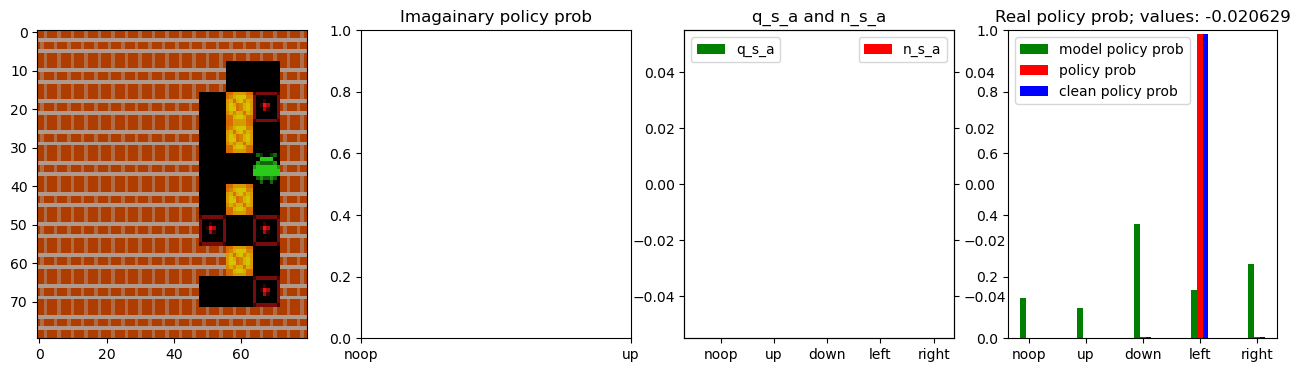

In [383]:
import matplotlib.ticker as mticker

def plot_obs(obs, ax=None, title=None):
    if ax is None: fig, ax = plt.subplots()
    ax.imshow(torch.swapaxes(torch.swapaxes(obs['frame'][0,0].cpu(),0,2),0,1), interpolation='nearest', aspect="auto")
    if title is not None: ax.set_title(title)
    
def plot_qn_sa(actor_net, ax=None):
    if ax is None: fig, ax = plt.subplots()
    q_s_a = actor_net.ret_dict["q_s_a"][0].detach().cpu().numpy()
    n_s_a = actor_net.ret_dict["n_s_a"][0].detach().cpu().numpy()
    xs = np.arange(len(q_s_a))

    ax.bar(xs - 0.3, q_s_a, color = 'g', width = 0.3, label="q_s_a")
    
    ax2 = ax.twinx()
    ax2.bar(xs, n_s_a, bottom=0, color = 'r', width = 0.3, label="n_s_a")

    ax.xaxis.set_major_locator(mticker.FixedLocator(np.arange(len(q_s_a))))
    ax.set_xticklabels(('noop', 'up', 'down', 'left', 'right'))    
    ax.legend(loc="upper left")   
    ax2.legend(loc="upper right") 
    ax.set_title("q_s_a and n_s_a")
        
def plot_policies(actor_net, actor_out, ax=None):
    if ax is None: fig, ax = plt.subplots()
    model_prob = torch.softmax(actor_net.ret_dict["logit0"], dim=-1)[0].detach().cpu().numpy()
    prob = torch.softmax(actor_out["policy_logits"], dim=-1)[0,0].detach().cpu().numpy()
    ax.set_title("Real policy prob; values: %4f" % actor_net.ret_dict["v0"][0].detach().cpu().numpy())
    
    core_state = actor_net.initial_state(bsz)
    core_state = tuple(v.to(flags.device) for v in core_state)
    done = torch.tensor([False]).bool().to(flags.device)
    actor_input = actor_net.use_model_aug(x=obs['frame'][0].to(flags.device),
                        r=torch.zeros_like(obs['reward'][0], device=flags.device), 
                        a=F.one_hot(torch.tensor([0], device=flags.device).long(), 5),
                        cur_t = 0., 
                        reset = torch.ones(1, device=flags.device))    
    actor_output_clean, core_state = actor_net.actor(actor_input, done=done, core_state=core_state, u=None)    
    prob_clean = torch.softmax(actor_output_clean["policy_logits"], dim=-1)[0].detach().cpu().numpy()
    
    xs = np.arange(len(model_prob))
    ax.bar(xs - 0.1, model_prob, color = 'g', width = 0.1, label="model policy prob")
    ax.bar(xs, prob, color = 'r', width = 0.1, label="policy prob")
    ax.bar(xs + 0.1, prob_clean, color = 'b', width = 0.1, label="clean policy prob")

    ax.xaxis.set_major_locator(mticker.FixedLocator(np.arange(len(model_prob))))
    ax.set_xticklabels(('noop', 'up', 'down', 'left', 'right'))
    ax.set_ylim(0, 1)        
    ax.legend()    
    
def plot_im_policies(actor_out, ax=None):
    im_prob = torch.softmax(actor_out["im_policy_logits"], dim=-1)[0][0].detach().cpu().numpy()
    reset_prob = torch.softmax(actor_out["reset_policy_logits"], dim=-1)[0,0,:,[0]].detach().cpu().numpy()
    im_reset_prob = np.concatenate([im_prob, reset_prob], axis=-1)
    if ax is None: fig, ax = plt.subplots()
    
    im_reset_prob = im_reset_prob[:-1]
    rec_t, num_actions = im_reset_prob.shape
    xs = np.arange(num_actions)
    for i in range(rec_t):
        ax.bar(xs + 0.6 * (i / rec_t), im_reset_prob[i], width = 0.6 / (rec_t))
    ax.xaxis.set_major_locator(mticker.FixedLocator(np.arange(num_actions)))
    ax.set_xticklabels(('noop', 'up', 'down', 'left', 'right', 'reset'))    
    ax.set_ylim(0, 1)   
    ax.set_title("Imagainary policy prob")
    plt.show()    
        
env = gym.vector.SyncVectorEnv([lambda: SokobanWrapper(gym.make("Sokoban-v0"), noop=True)] * bsz)
env = Vec_Environment(env, bsz)
core_state = actor_net.initial_state(bsz)
core_state = tuple(v.to(flags.device) for v in core_state)
returns = []
obs = env.initial()
obs = {k:v.to(flags.device) for k, v in obs.items()}   

actor_out, core_state = actor_net(obs, core_state, debug=False)
fig, axs = plt.subplots(1, 4, figsize=(16,4))  
plot_obs(obs, axs[0])    
plot_qn_sa(actor_net, axs[2]) 
plot_policies(actor_net, actor_out, axs[3])    
plot_im_policies(actor_out, axs[1])    

In [388]:
actor_output["reset_policy_logits"]

tensor([[-1.8545e-05,  0.0000e+00]], device='cuda:0',
       grad_fn=<SelectBackward0>)

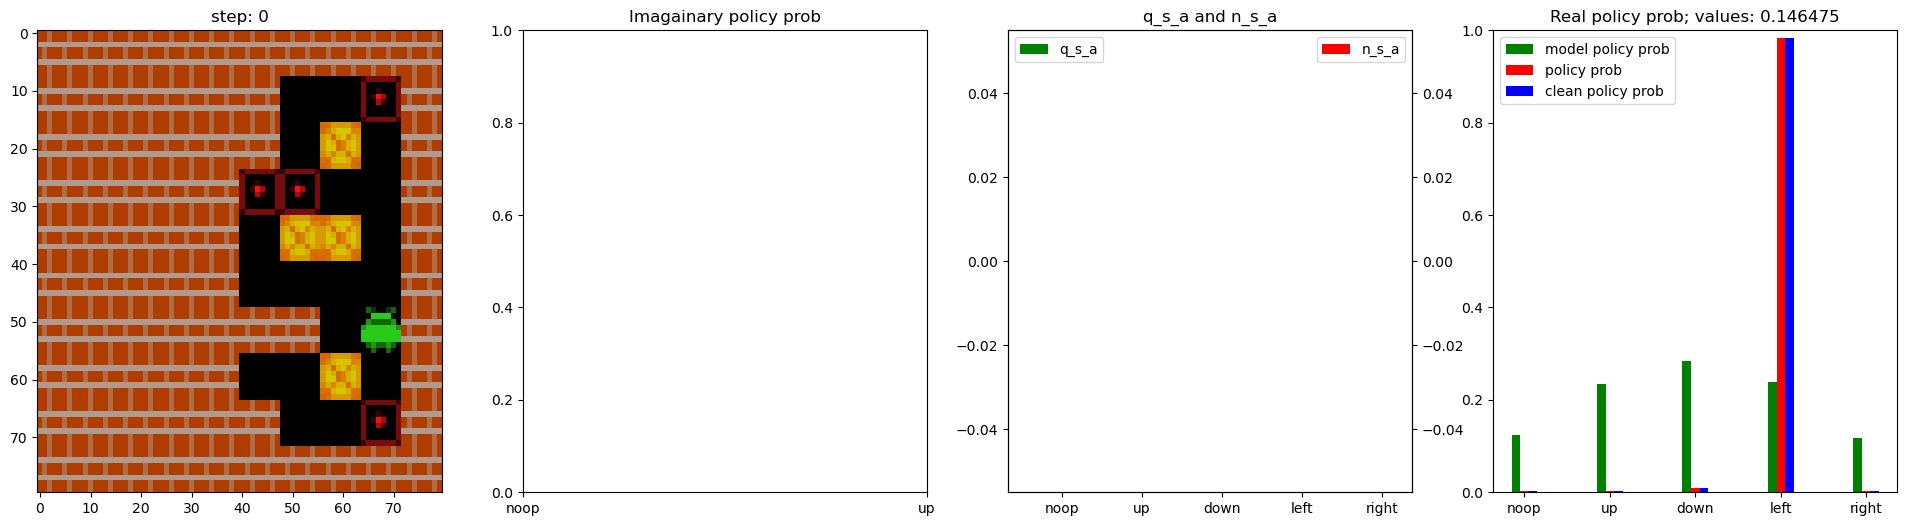

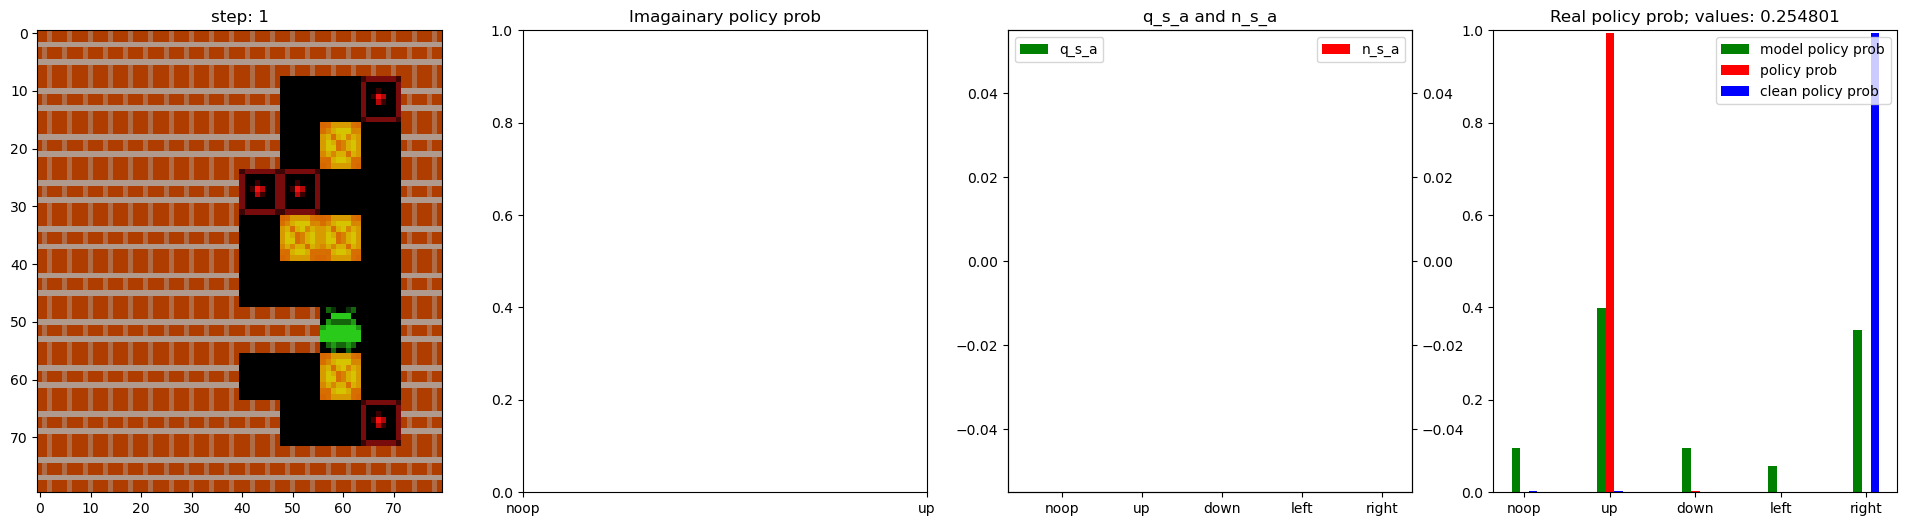

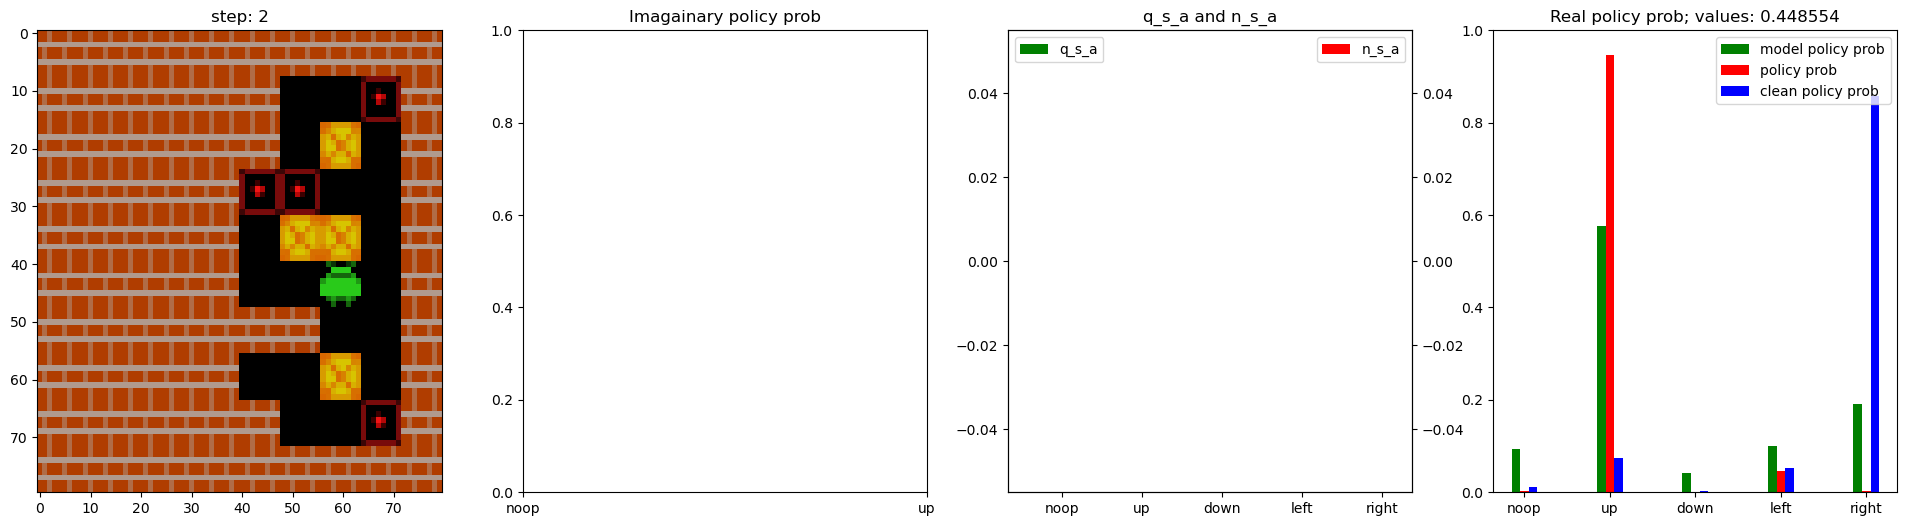

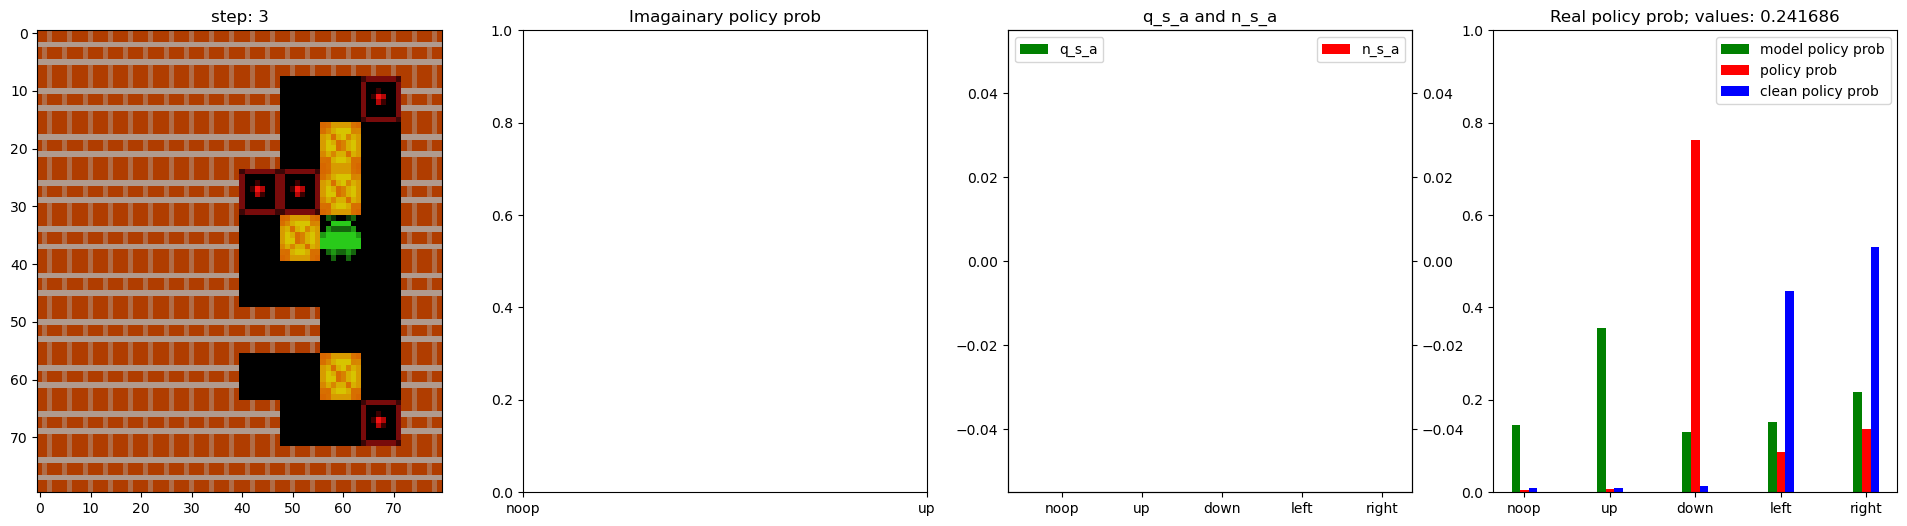

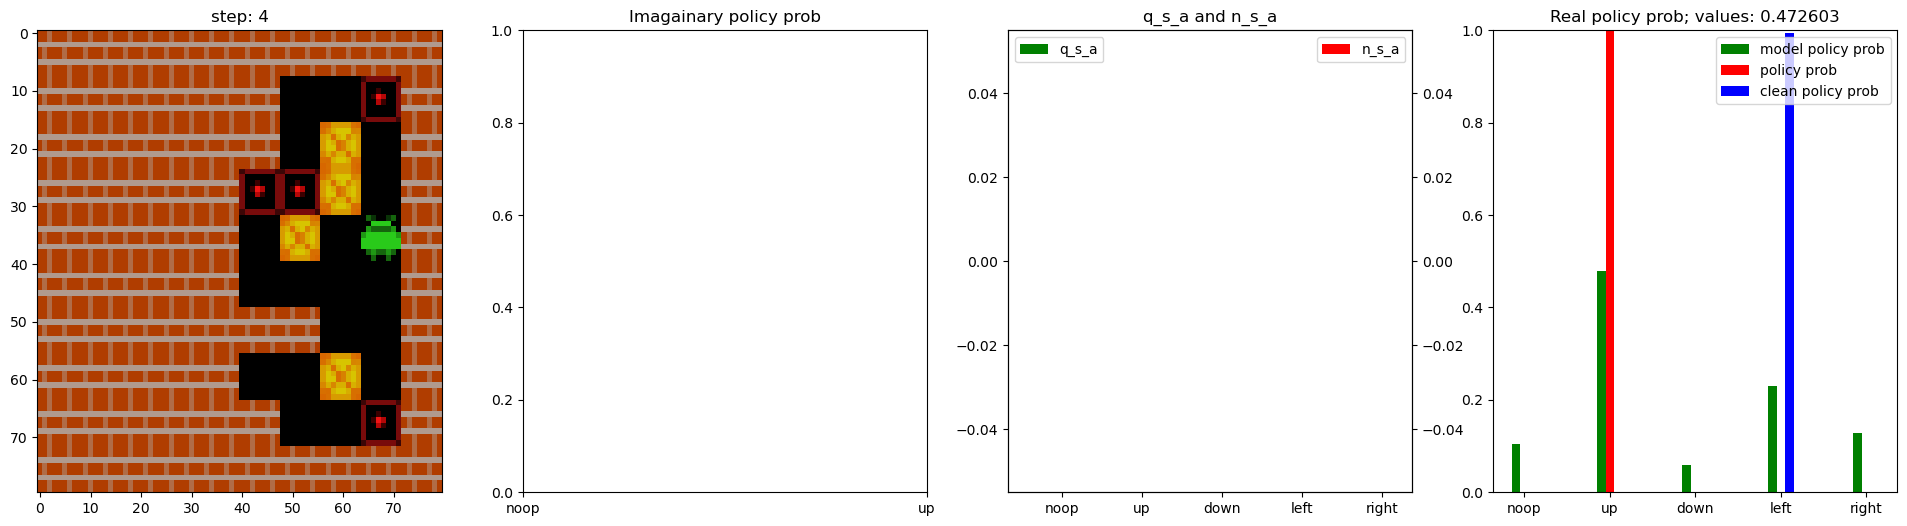

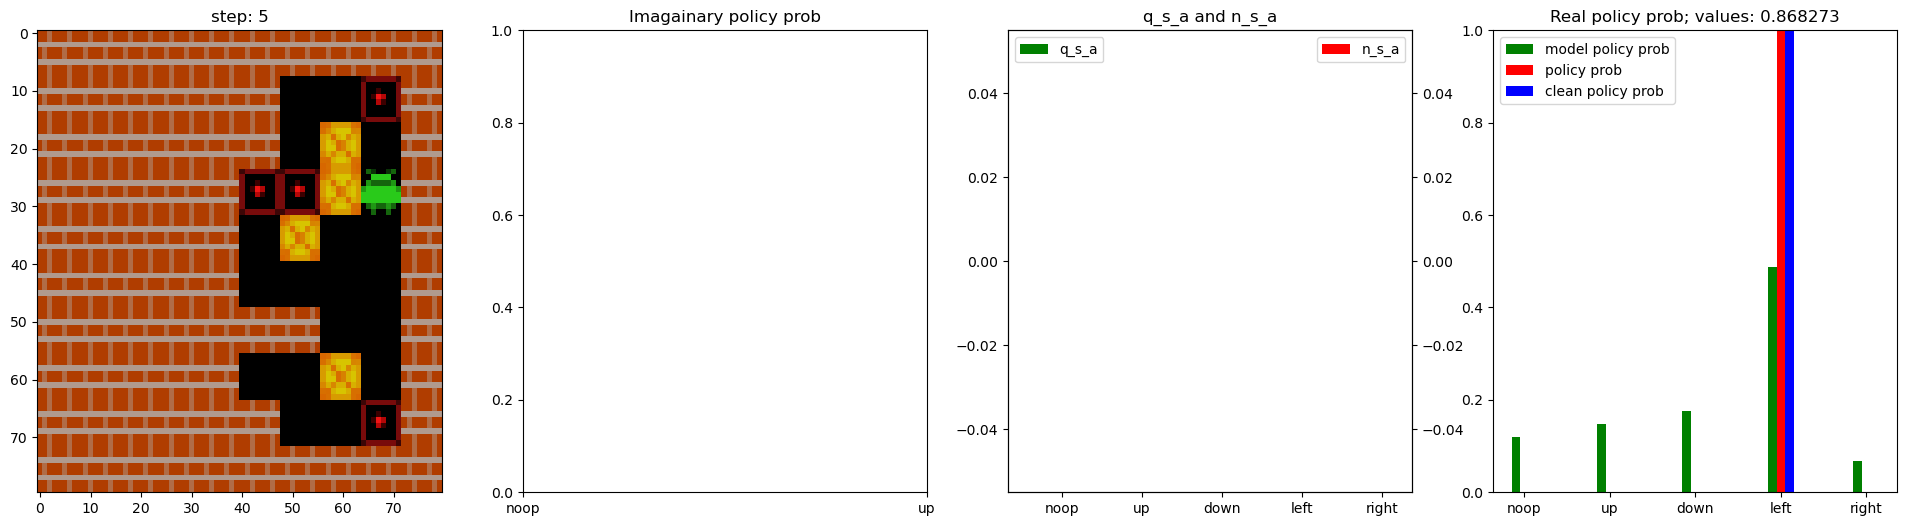

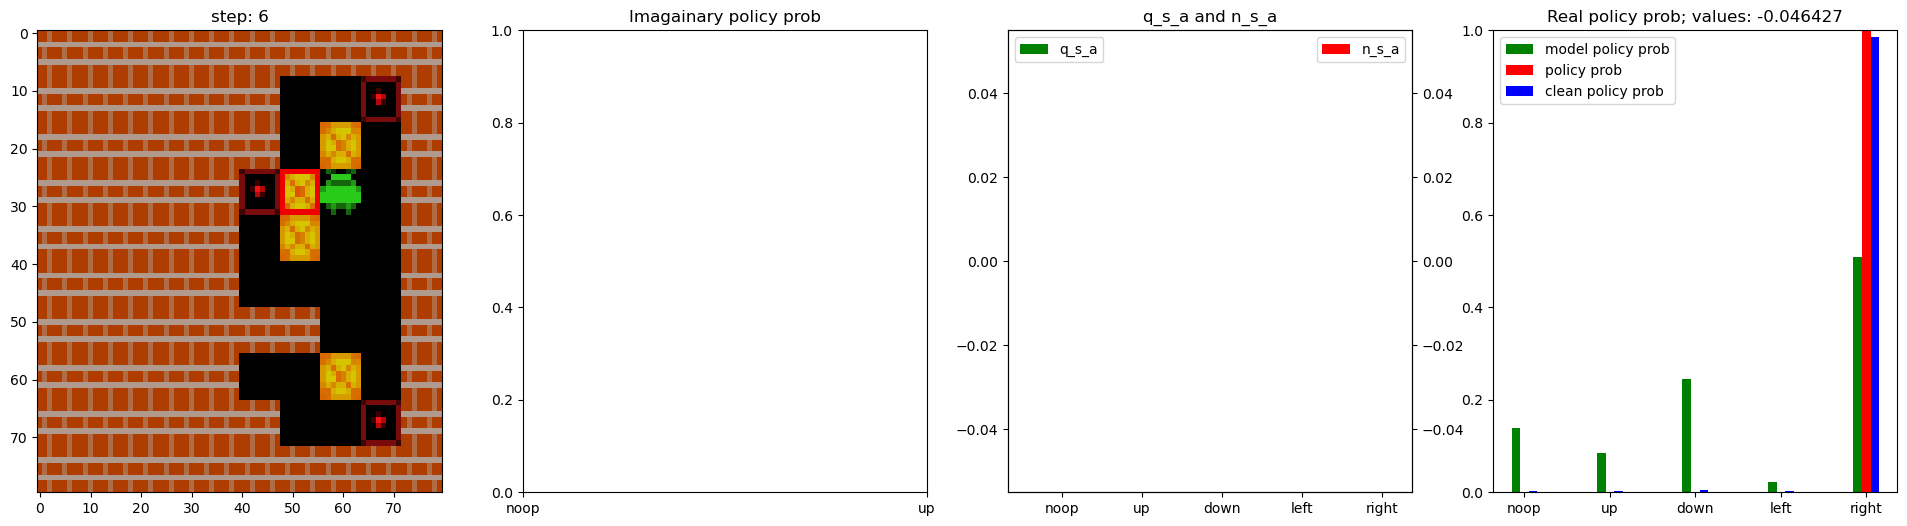

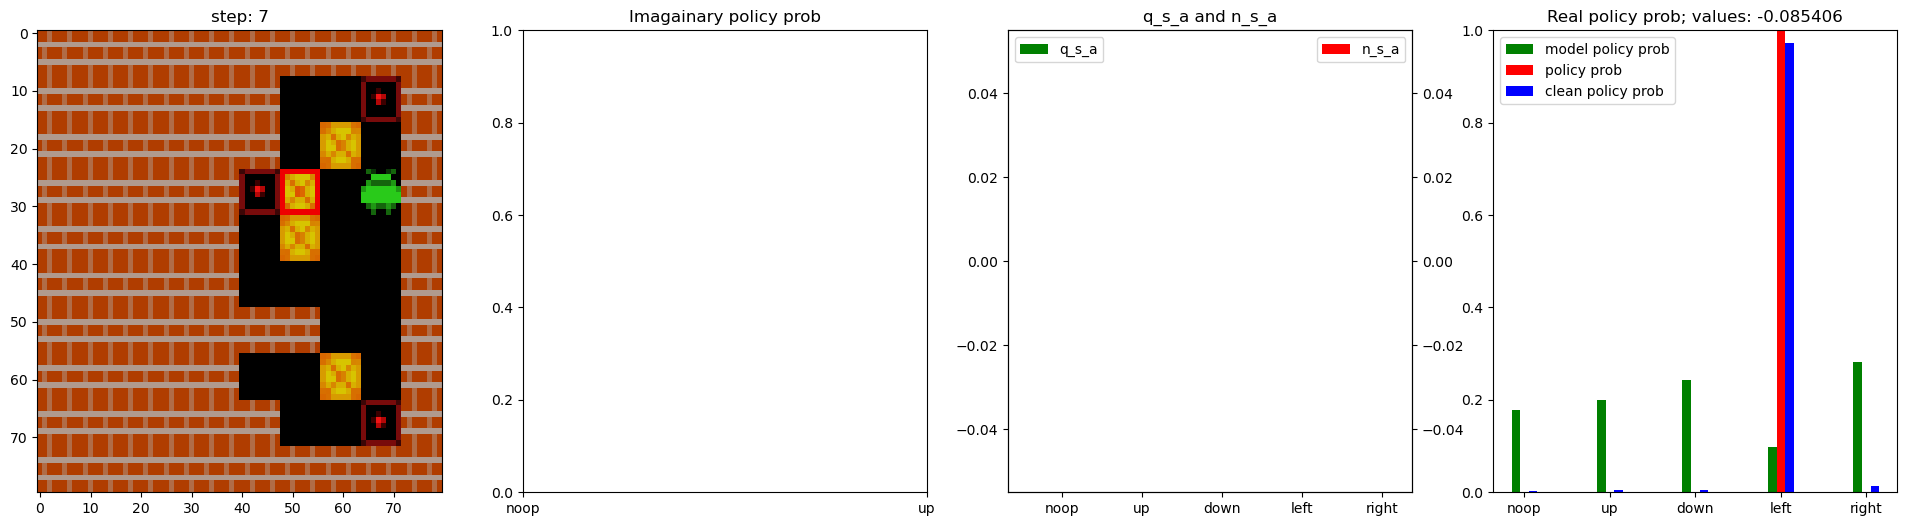

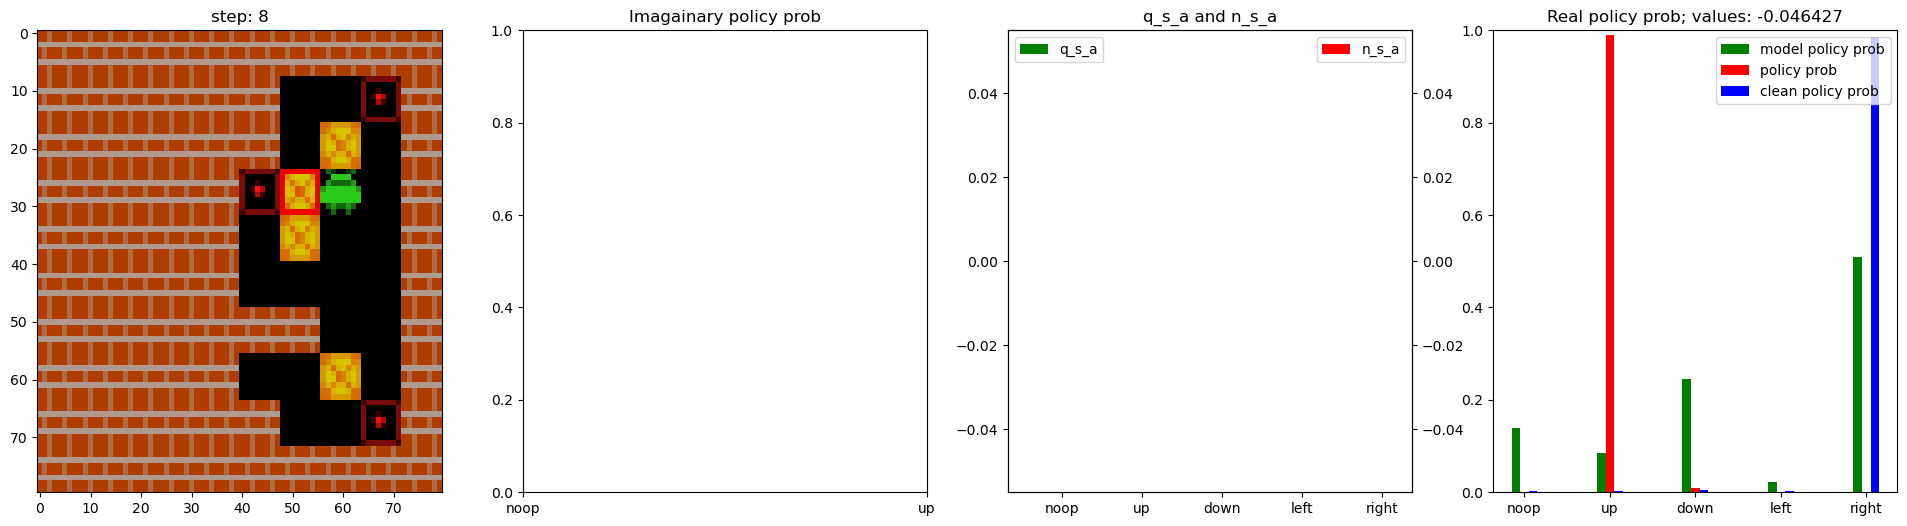

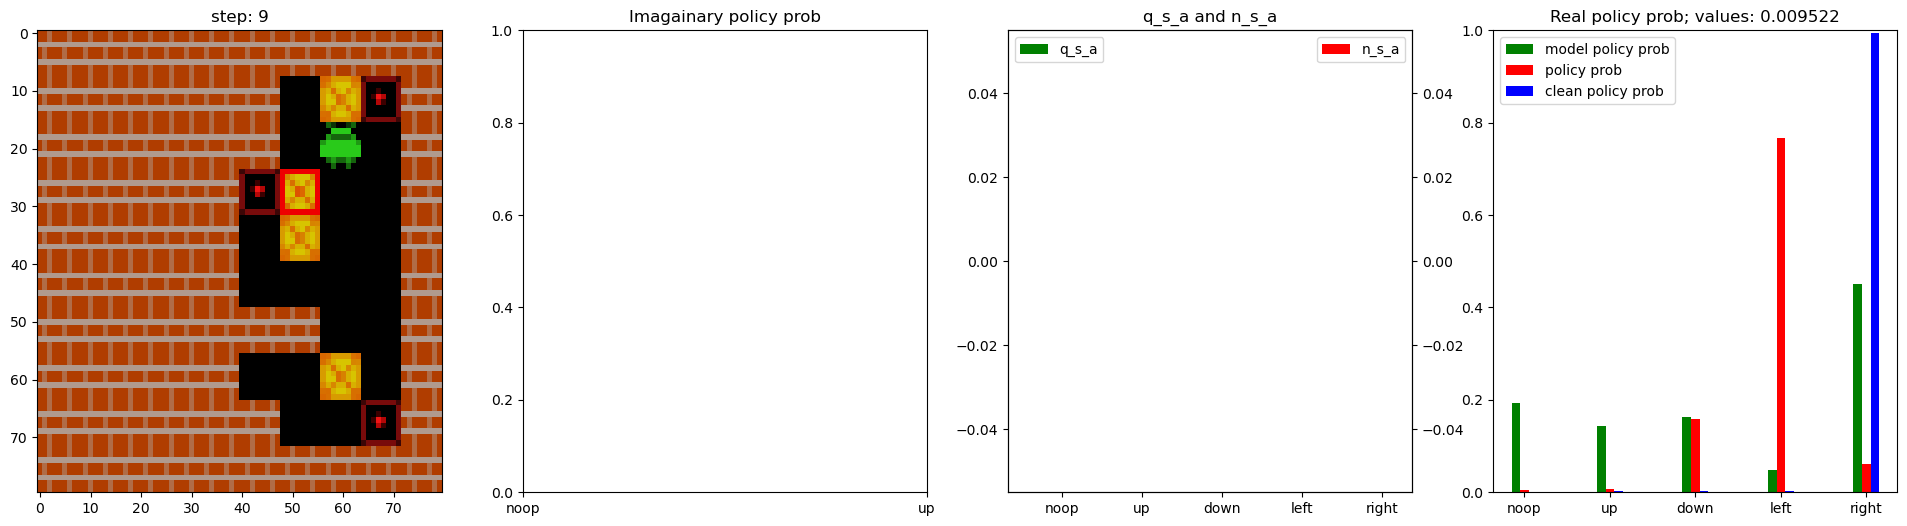

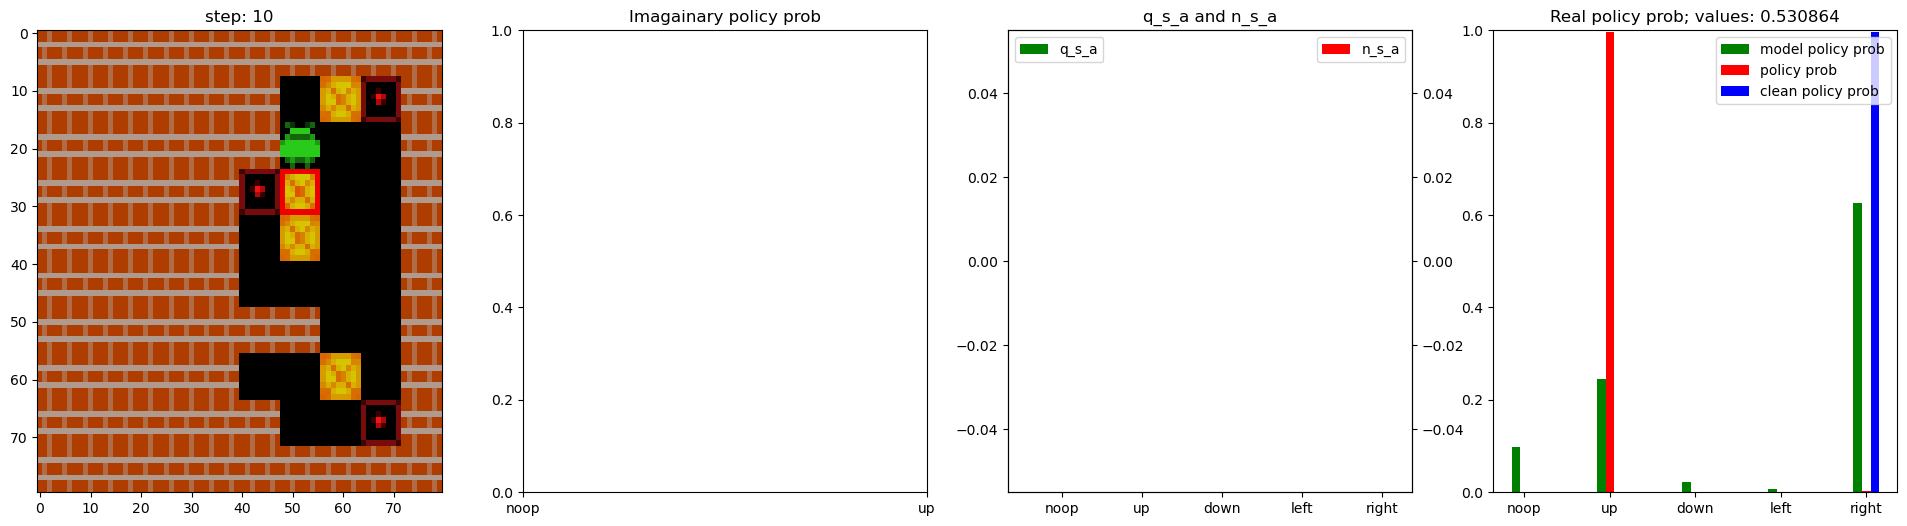

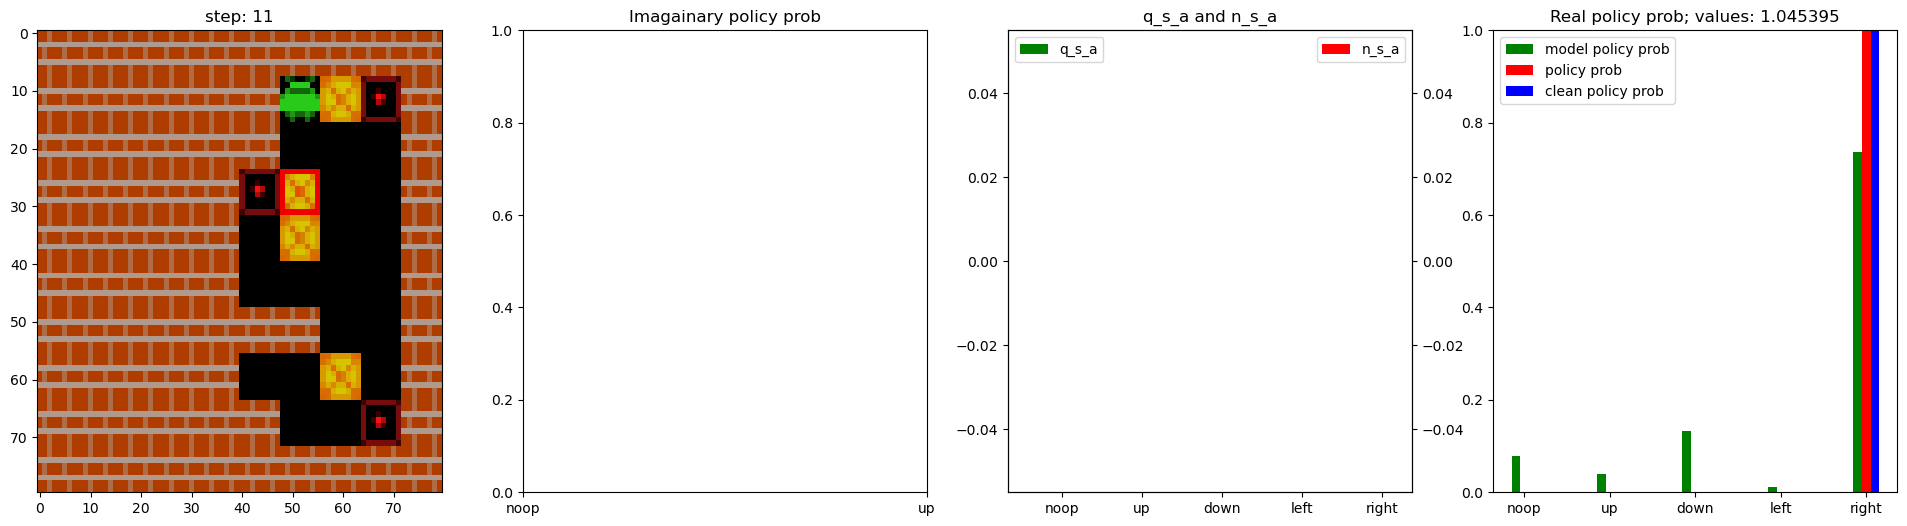

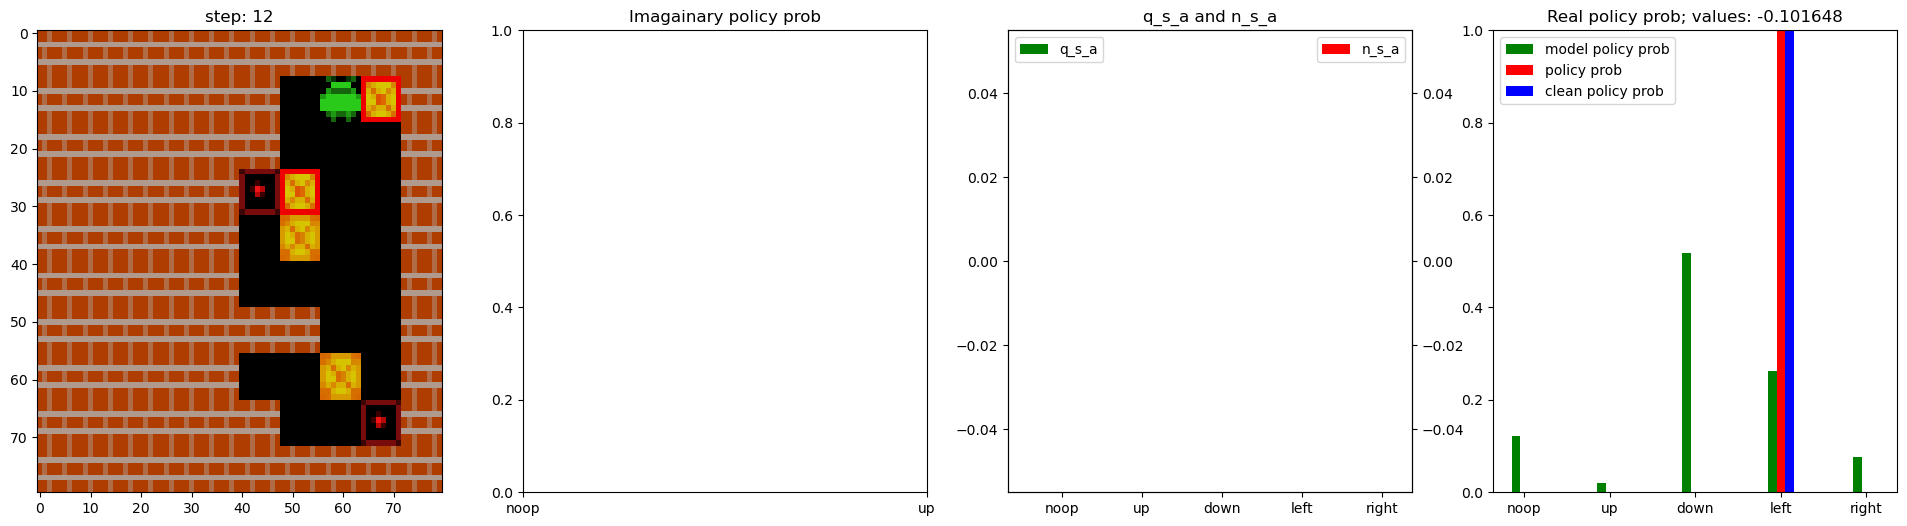

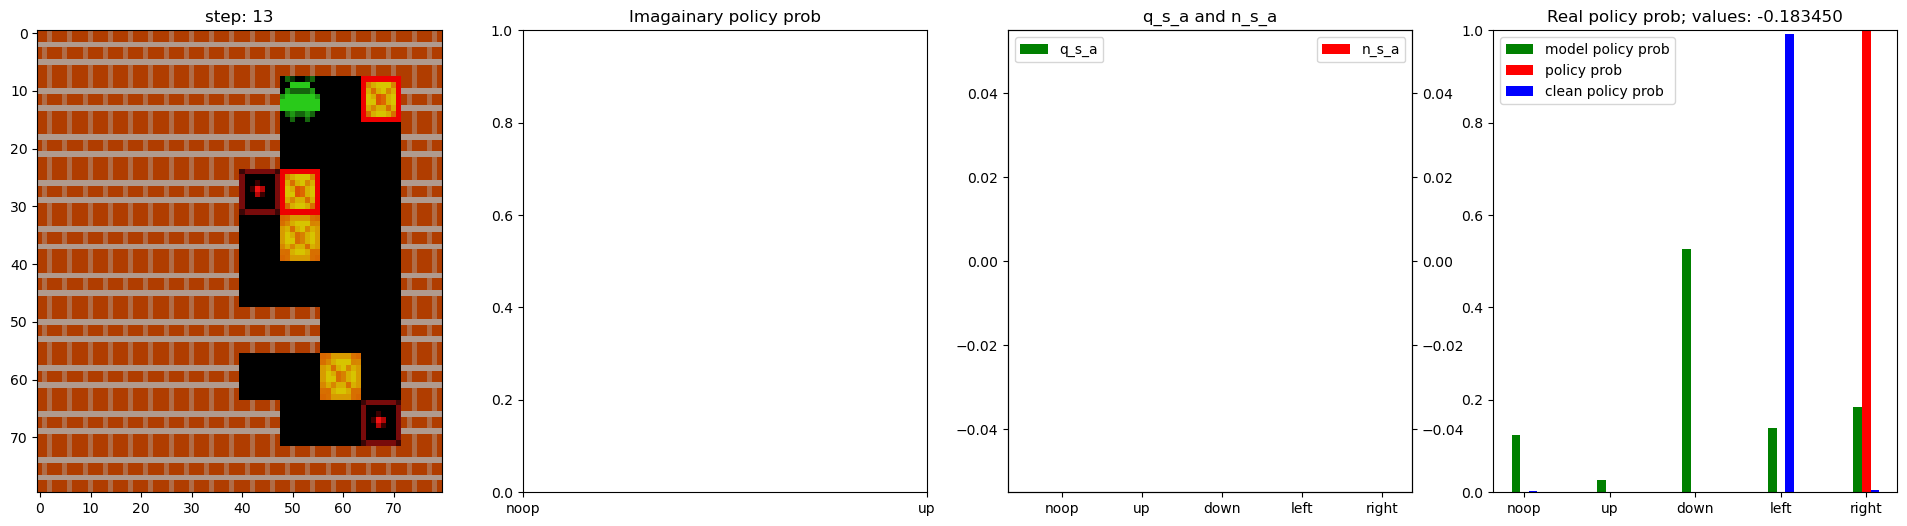

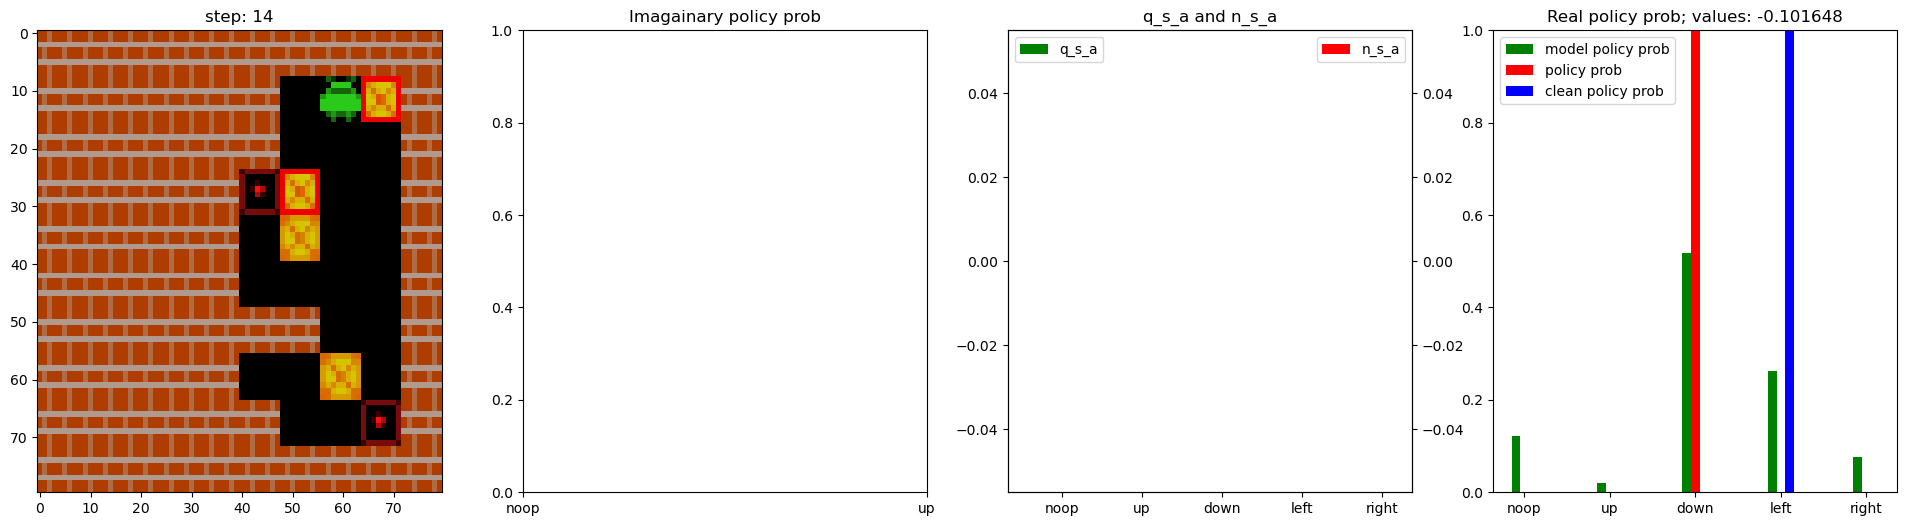

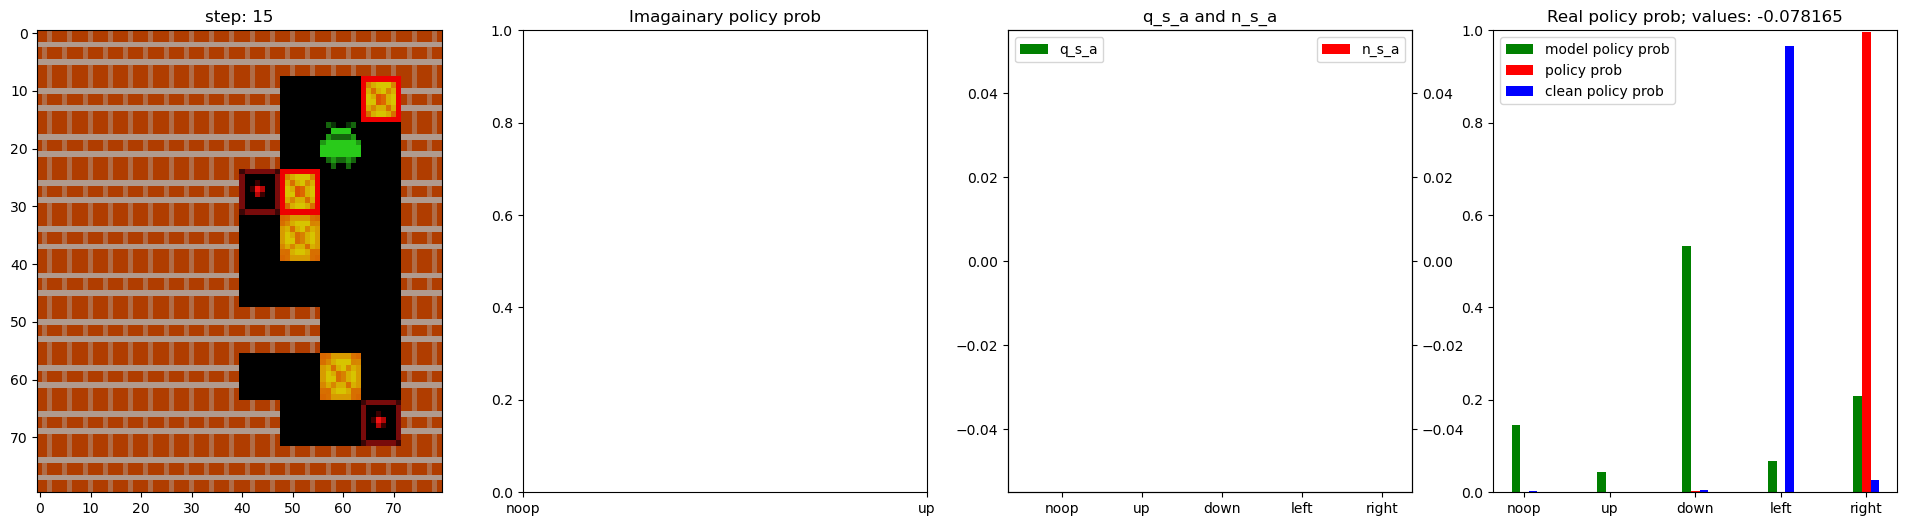

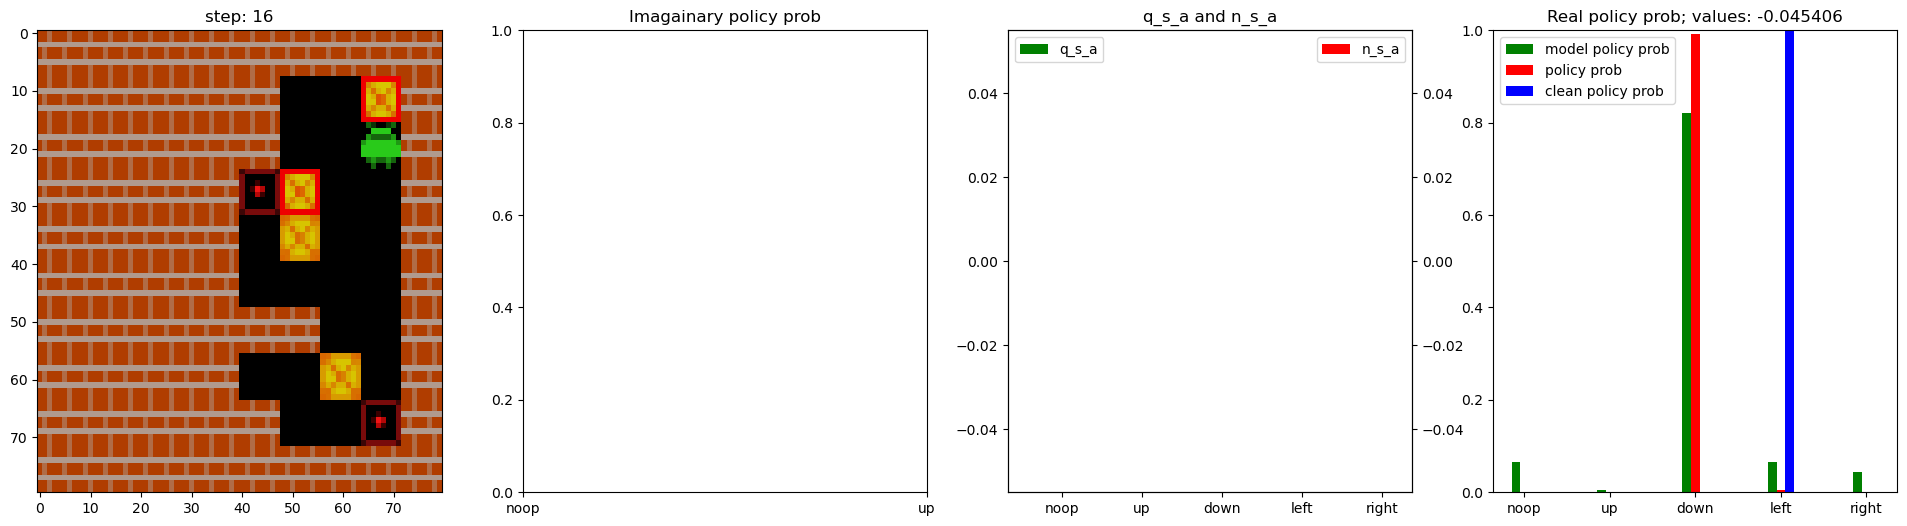

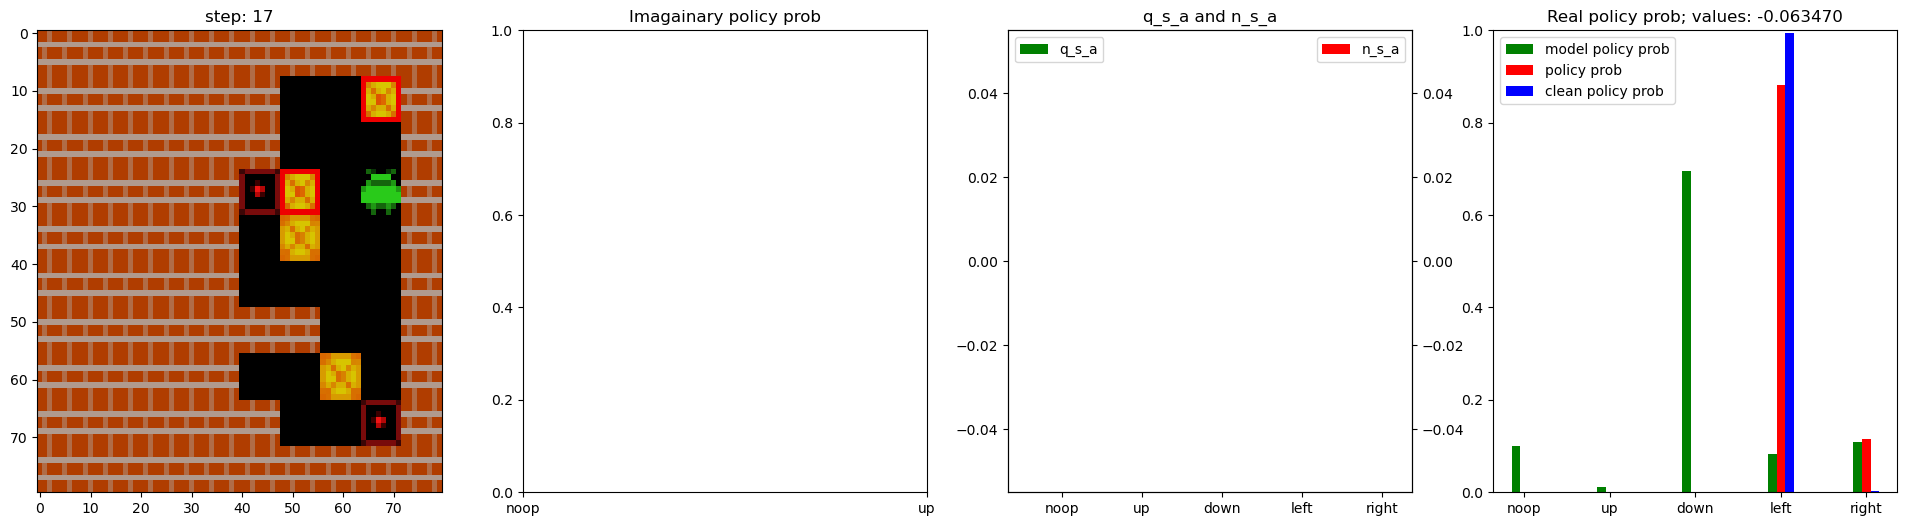

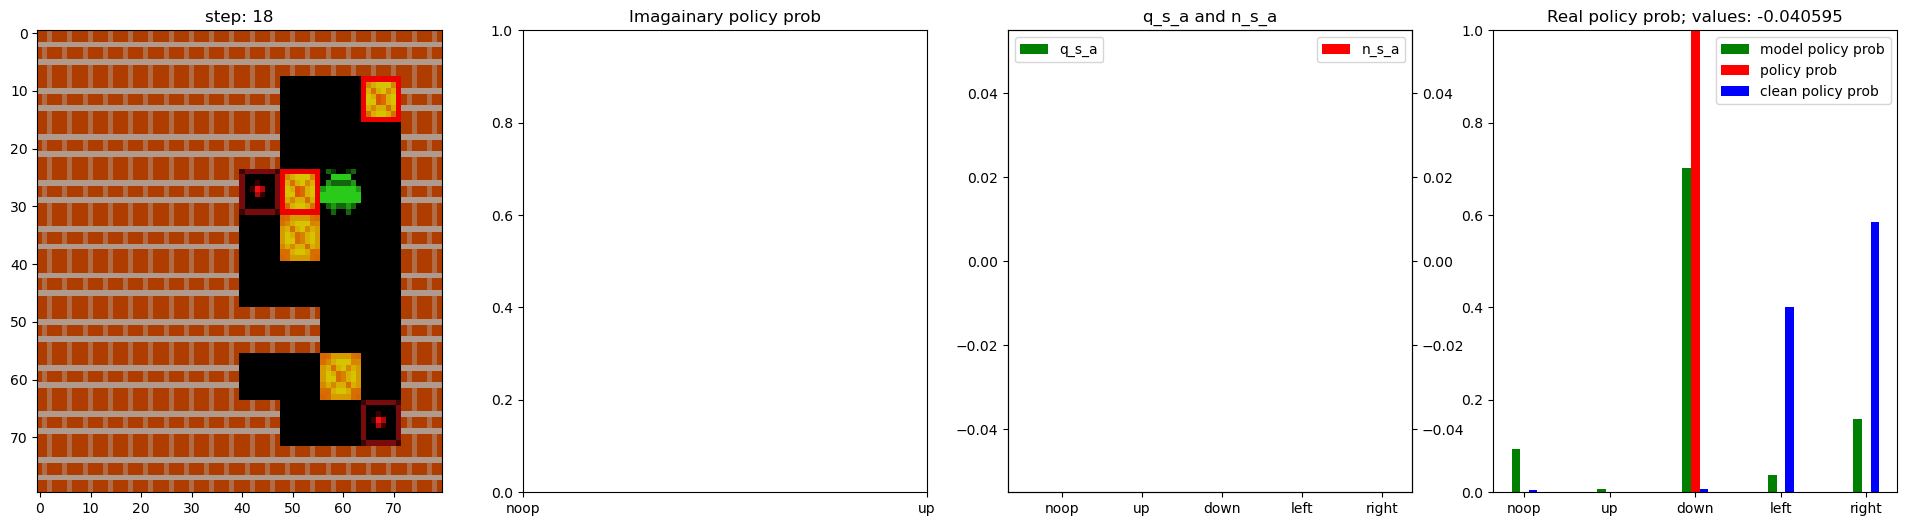

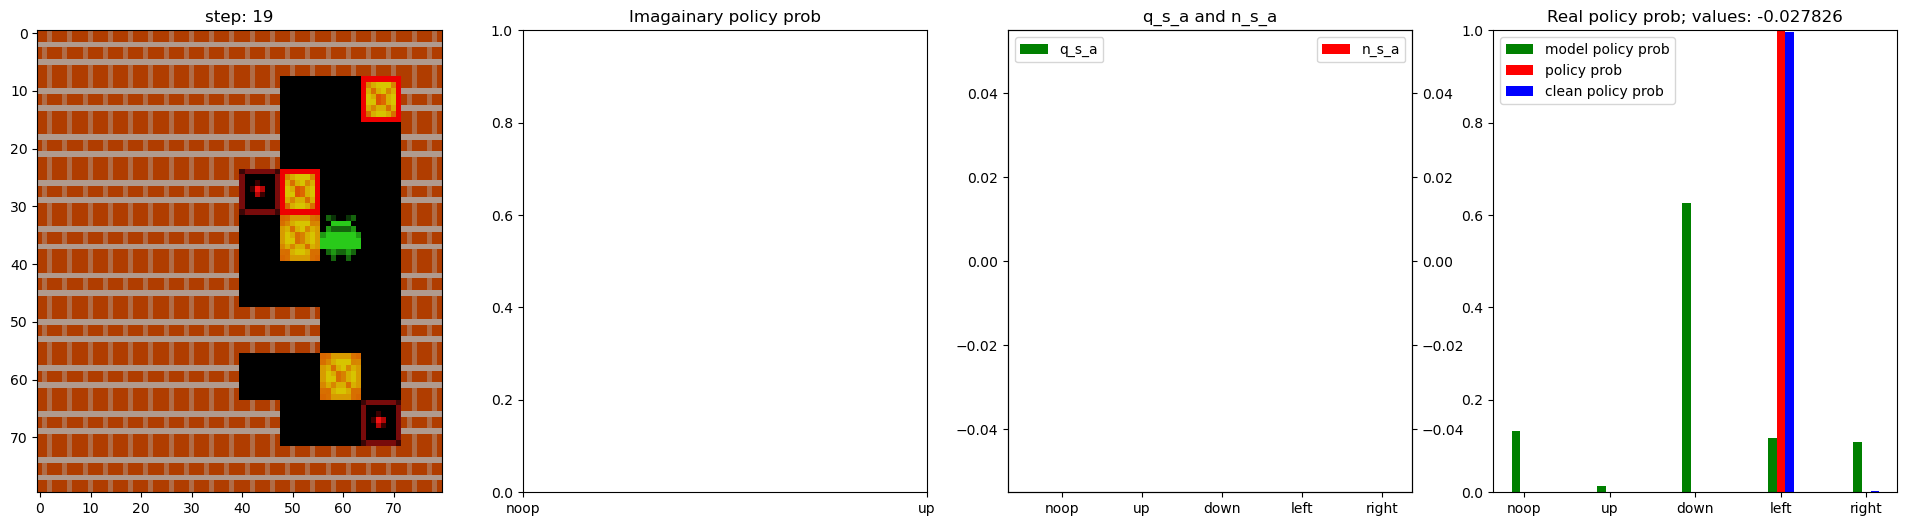

KeyboardInterrupt: 

In [384]:
debug = True

env = gym.vector.SyncVectorEnv([lambda: SokobanWrapper(gym.make("Sokoban-v0"), noop=True)] * bsz)
env = Vec_Environment(env, bsz)
core_state = actor_net.initial_state(bsz)
core_state = tuple(v.to(flags.device) for v in core_state)
returns = []
obs = env.initial()

t = 0
while(True):
    if (t > 100 and debug) or (len(returns) > eps_n and not debug): break    
    with torch.no_grad():
        cur_returns = obs['episode_return']    
        obs = {k:v.to(flags.device) for k, v in obs.items()}    
        if debug: 
            fig, axs = plt.subplots(1, 4, figsize=(24,6))  
            plot_obs(obs, axs[0], title="step: %d" %t)                
        actor_out, core_state = actor_net(obs, core_state, debug=False)
        if debug: 
            plot_qn_sa(actor_net, axs[2]) 
            plot_policies(actor_net, actor_out, axs[3])    
            plot_im_policies(actor_out, axs[1])    
            im_prob = torch.softmax(actor_out["im_policy_logits"], dim=-1)[0][0].detach().cpu().numpy()
            plt.show()
        obs = env.step(actor_out["action"][0])
        if torch.any(obs['done']):
            returns.extend(cur_returns[obs['done']].numpy())
    t += 1

returns = returns[:eps_n]            
print("Finish %d episode: avg. return: %.2f (+-%.2f) " % (len(returns),
      np.average(returns), np.std(returns) / np.sqrt(len(returns))))        

In [85]:
core_state = actor_net.initial_state(bsz)
core_state = tuple(v.to(flags.device) for v in core_state)
actor_input = torch.tensor([ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.3049, -1.8309,
         0.0480, -0.0950,  0.0068, -3.2205,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  1.0000,  0.0000,  1.3049, -1.8309,  0.0480, -0.0950,  0.0068,
        -3.2205,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  1.0000,  1.0309]).unsqueeze(0).unsqueeze(-1).unsqueeze(-1).to(flags.device)
done = torch.tensor([False]).bool().to(flags.device)
actor_output, core_state = actor_net.actor(actor_input, done=done, core_state=core_state, u=None)
print(actor_output['policy_logits'].cpu().detach().numpy())
print(F.softmax(actor_output['policy_logits'], dim=-1).cpu().detach().numpy())


[[-1.69783     0.547552   -0.02001478  5.046454   -4.0599318 ]]
[[0.00115596 0.0109169  0.00618882 0.9816295  0.00010892]]


In [66]:
# Change the model to another one

parser = define_parser()        
flags = parser.parse_args("--env Sokoban-v0".split())        
flags.device = torch.device("cuda")
env = create_env(flags)
obs_shape, num_actions = env.observation_space.shape, env.action_space.n

model = Model(flags, obs_shape, num_actions=num_actions).to(device=flags.device)
checkpoint = torch.load("/home/sc/RS/thinker/models/model_3.tar")
model.load_state_dict(checkpoint["model_state_dict"])  

model.train(False)
actor_net.model = model

In [ ]:
# Testing actor wrapper with a one-step greedy actor

def n_step_greedy_model(state, action, model, n, encoded=None, temp=20.): 
    
    # Either input state, action (S_t, A_{t-1}) or the encoded Z_t
    # state / encoded in the shape of (B, C, H, W)
    # action in the shape of (B)
    
    bsz = state.shape[0] if encoded is None else encoded.shape[0]
    device = state.device if encoded is None else encoded.device
    num_actions = model.num_actions    
    
    q_ret = torch.zeros(bsz, num_actions).to(device)        
    
    for act in range(num_actions):        
        new_action = torch.Tensor(np.full(bsz, act)).long().to(device)    
        if encoded is None:            
            old_new_actions = torch.concat([action.unsqueeze(0), new_action.unsqueeze(0)], dim=0)
            rs, vs, logits, encodeds = model(state, old_new_actions)
        else:
            rs, vs, logits, encodeds = model.forward_encoded(encoded, new_action.unsqueeze(0))
        
        if n > 1:
            action, prob, sub_q_ret = n_step_greedy_model(state=None, action=None, 
                       model=model, n=n-1, encoded=encodeds[1])
            ret = rs[0] + flags.discounting * torch.max(sub_q_ret, dim=1)[0] 
        else:
            ret = rs[0] + flags.discounting * vs[1]
            #print(rs[0], vs[1])
        q_ret[:, act] = ret
    
    prob = F.softmax(temp*q_ret, dim=1)
    action = torch.multinomial(prob, num_samples=1)[:, 0]
    
    return action, prob, q_ret        

class Actor_test(nn.Module):
    # A one-step greedy actor (for testing only)
    def __init__(self, num_actions, rec_t):
        super(Actor_test, self).__init__()  
        self.num_actions = num_actions
        self.rs = torch.zeros(num_actions)
        self.vs = []
        self.rec_t = rec_t
        self.gb_ste = False
        self.time = 0
    
    def forward(self, x, done, core_state=None, u=None):
        
        x = x[:, :, 0, 0]        
        #print("Input: ", x[0])
        bsz = x.shape[0]
        rec_t = self.rec_t
        t = self.time     
        
        if t == 0:
            self.rs = torch.zeros(rec_t, bsz, device=x.device)
            self.vs = torch.zeros(rec_t, bsz, device=x.device)
        self.rs[t] = x[:, 18] #x[:,1+self.num_actions]        
        self.vs[t] = x[:, 19] #x[:,2+self.num_actions]
        print(t, x)
        
        im_action = torch.tensor(t) if t < self.num_actions else torch.zeros(1, device=x.device).long()
        im_action = F.one_hot(im_action.unsqueeze(0), self.num_actions).tile([bsz, 1])
        reset = torch.ones(bsz, device=x.device)
        
        policy_logits = (self.rs[1:1+self.num_actions] + flags.discounting * self.vs[1:1+self.num_actions]).transpose(0, 1) 
        policy_probs = F.softmax(20 * policy_logits, dim=1)
        action = torch.multinomial(policy_probs, num_samples=1)
        
        ret = {"im_policy_logits": im_action, 
               "im_action": im_action, 
               "reset_policy_logits": reset, 
               "reset": reset,                
               "policy_logits": policy_logits, 
               "policy_probs": policy_probs, 
               "action": action,
               "baseline": torch.zeros_like(reset),
               "reg_loss": torch.zeros_like(reset)}
        
        self.time += 1
        return (ret, None)

model = Model(flags, obs_shape, num_actions=num_actions)
checkpoint = torch.load("../models/model_1.tar")
model.load_state_dict(checkpoint["model_state_dict"])     
model.train(False)    

parser = argparse.ArgumentParser()
flags = parser.parse_args("".split())   
flags.discounting = 0.97
flags.aug_stat = True
flags.rec_t = 6

actor = Actor_test(num_actions=model.num_actions,rec_t=flags.rec_t)        
actor_wrapper = Actor_Wrapper(flags, model, actor)
        
bsz = 2
env = gym.vector.SyncVectorEnv([lambda: SokobanWrapper(gym.make("Sokoban-v0"), noop=True)] * bsz)
env = Vec_Environment(env, bsz)
obs = env.initial()
state = obs['frame'][0].clone()
action = torch.zeros(bsz).long()

#obs = {k:v.to(flags.device).view((1, 10)+v.shape[2:]) for k, v in obs.items()}
#obs = {k:v.to(flags.device) for k, v in obs.items()}
actor_output, _ = actor_wrapper(obs)
print(F.softmax(20 * actor_output['policy_logits'], dim=-1))
action, prob, q_ret = n_step_greedy_model(state, action, model, 1, encoded=None, temp=20.)
print(prob)

<font size="5">Misc.</font>

In [ ]:
batch = get_batch_m(flags, buffers)
print(torch.max(batch["reward"]), (torch.max(batch["reward"]) == batch["reward"]).nonzero())
print(batch["done"].nonzero())

In [ ]:
batch["reward"][:, 12]

In [ ]:
# DEBUG LOSS

#batch = get_batch_m(flags, buffers)

model.train(False)

rs, vs, logits, _ = model(batch['frame'][0], batch['action'])
logits = logits[:-1]

target_rewards = batch['reward'][1:]
target_logits = batch['policy_logits'][1:]

target_vs = []
target_v = model(batch['frame'][-1], batch['action'][[-1]])[1][0]    

for t in range(vs.shape[0]-1, 0, -1):
    new_target_v = batch['reward'][t] + flags.discounting * (target_v * (~batch['done'][t]).float() +
                       vs[t-1] * (batch['truncated_done'][t]).float())
    target_vs.append(new_target_v.unsqueeze(0))
    target_v = new_target_v
target_vs.reverse()
target_vs = torch.concat(target_vs, dim=0)

# if done on step j, r_{j}, v_{j-1}, a_{j-1} has the last valid loss 
# rs is stored in the form of r_{t+1}, ..., r_{t+k}
# vs is stored in the form of v_{t}, ..., v_{t+k-1}
# logits is stored in the form of a{t}, ..., a_{t+k-1}

done_masks = []
done = torch.zeros(vs.shape[1]).bool().to(batch['done'].device)
for t in range(vs.shape[0]):
    done = torch.logical_or(done, batch['done'][t])
    done_masks.append(done.unsqueeze(0))

done_masks = torch.concat(done_masks[:-1], dim=0)

# compute final loss
huberloss = torch.nn.HuberLoss(reduction='none', delta=1.0)    
rs_loss = torch.sum(huberloss(rs, target_rewards) * (~done_masks).float())
#rs_loss = torch.sum(((rs - target_rewards) ** 2) * (~r_logit_done_masks).float())
vs_loss = torch.sum(huberloss(vs[:-1], target_vs) * (~done_masks).float())
#vs_loss = torch.sum(((vs[:-1] - target_vs) ** 2) * (~v_done_masks).float())
logits_loss = compute_cross_entropy_loss(logits, target_logits, done_masks)

# debug
ind = 21

target_vs = []
target_v = vs[-1]
for t in range(vs.shape[0]-1, 0, -1):        
    new_target_v = batch['reward'][t] + flags.discounting * (target_v * (~batch['done'][t]).float() +
                       vs[t-1] * (batch['truncated_done'][t]).float())
    print(t, 
          "reward %2f" % batch['reward'][t,ind].item(), 
          "bootstrap %2f" % (target_v * (~batch['done'][t]).float())[ind].item(), 
          "truncated %2f" % (vs[t-1] * (batch['truncated_done'][t]).float())[ind].item(),
          "vs[t-1] %2f" % vs[t-1][ind].item(),
          "new_targ %2f" % new_target_v[ind].item())
    target_vs.append(new_target_v.unsqueeze(0))    
    target_v = new_target_v
target_vs.reverse()
target_vs = torch.concat(target_vs, dim=0)   
print("done", batch["done"][:, ind])
print("done_masks", done_masks[:, ind])
print("vs: ", vs[:, ind])
print("target_vs: ", target_vs[:, ind])
print("reward: ", rs[:, ind])
print("target_reward: ", target_rewards[:, ind])
print("logits: ", logits[:, ind])
print("target_logits: ", target_logits[:, ind])

In [ ]:
# alt. version of computing loss by treading terminal state as absorbing state (as in MuZero)

def compute_loss_m(model, batch):

    rs, vs, logits, _ = model(batch['frame'][0], batch['action'])
    logits = logits[:-1]

    target_logits = batch['policy_logits'][1:].clone()
    target_rewards = batch['reward'][1:].clone()

    done_masks = []
    done = torch.zeros(vs.shape[1]).bool().to(batch['done'].device)

    c_logits = target_logits[0]
    c_state = batch['frame'][0]
    for t in range(vs.shape[0]-1):
        if t > 0: done = torch.logical_or(done, batch['done'][t])
        c_logits = torch.where(done.unsqueeze(-1), c_logits, target_logits[t])
        target_logits[t] = c_logits
        c_state = torch.where(done.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1), c_state, batch['frame'][t])  
        done_masks.append(done.unsqueeze(0))
    done_masks = torch.concat(done_masks, dim=0)
    done = torch.logical_or(done, batch['done'][-1])
    c_state = torch.where(done.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1), c_state, batch['frame'][-1])
    target_rewards = target_rewards * (~done_masks).float()

    target_vs = []
    target_v = model(c_state, batch['action'][[-1]])[1][0].detach()
    
    for t in range(vs.shape[0]-1, 0, -1):
        new_target_v = batch['reward'][t] + flags.discounting * target_v
        target_vs.append(new_target_v.unsqueeze(0))
        target_v = new_target_v
    target_vs.reverse()
    target_vs = torch.concat(target_vs, dim=0)
    
    # compute final loss
    huberloss = torch.nn.HuberLoss(reduction='none', delta=1.0)    
    rs_loss = torch.sum(huberloss(rs, target_rewards.detach()))
    #rs_loss = torch.sum(((rs - target_rewards) ** 2) * (~r_logit_done_masks).float())
    vs_loss = torch.sum(huberloss(vs[:-1], target_vs.detach()))
    #vs_loss = torch.sum(((vs[:-1] - target_vs) ** 2) * (~v_done_masks).float())
    logits_loss = compute_cross_entropy_loss(logits, target_logits.detach(), None)
    
    return rs_loss, vs_loss, logits_loss